In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr, ks_2samp
import ast
from PIL import Image
import os
from adjustText import adjust_text

In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [5]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [6]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# GPCRs

In [8]:
# Read GPCRs
gpcrs = pd.read_csv('/home/fraimondi/BIOINFO1_BK/francesco/GPCR/gpcrs_genes.txt')['Symbol'].values

# Read ligands
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv')
lr = lr[lr.receptor.isin(gpcrs)]

# Read G-Proteins coupling
gprots_couplings = pd.read_csv('/home/lnemati/resources/gpcr_couplings/gpcr_couplings.csv')
gprots_couplings = gprots_couplings.query('n_sources >=3')
gprots_couplings = gprots_couplings.query('type != "precogx_only"')
gprots_couplings.set_index('gpcr', inplace=True, drop=False)
gprots_couplings.index.name = None
gprots_couplings = gprots_couplings.groupby('gpcr')['gprot'].apply(list)
gprots = gprots_couplings.values.sum()


In [9]:
# Get G-Proteins, GPCRs and their ligands
gpcrs_genes = set(gpcrs) | set(gprots) | set(lr.ligand.values) | set(lr.receptor.values)

In [10]:
ncoev = pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/normal_jaccard_coevolution.csv', index_col=0)

df = pd.DataFrame(columns=['gpcr', 'interactor', 'interactor_type', 'condition', 'value'])

for gpcr in gprots_couplings.index.intersection(ncoev.index):
    couplings = ncoev.index.intersection(gprots_couplings.loc[gpcr])
    values = ncoev.loc[gpcr, couplings].to_frame(name = 'value')
    values['gpcr'] = gpcr
    values['interactor'] = values.index
    values['interactor_type'] = 'G-Protein'
    values['tissue'] = 'Coevolution'
    values['condition'] = 'Coevolution'
    values['value_type'] = 'jaccard'

    df = pd.concat([df, values])
    
for gpcr in ncoev.index.intersection(lr.receptor.unique()):
    ligands = ncoev.index.intersection(lr[lr['receptor'] == gpcr].ligand.unique())
    values = ncoev.loc[gpcr, ligands].to_frame(name = 'value')
    values['gpcr'] = gpcr
    values['interactor'] = values.index
    values['interactor_type'] = 'Ligand'
    values['tissue'] = 'Coevolution'
    values['condition'] = 'Coevolution'
    values['value_type'] = 'jaccard'

    df = pd.concat([df, values])

df = df.reset_index(drop=True)

In [11]:
df = pd.concat([df, pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/all_gpcr_interactions.csv')])
#df = df[df['subtissue'] != 'testis']
df.query('not (subtissue == "testis" and condition == "normal")')
df = df.groupby(['gpcr', 'interactor', 'condition', 'interactor_type', 'tissue', 'value_type'], as_index=False)['value'].mean()
df = df.query('value_type in ["correlation", "jaccard"]')
df['condition'] =df['condition'].replace({'normal': 'Normal Co-Expression', 'tumor': 'Tumor Co-Expression'})

In [12]:
#print('Tumor: ligands vs gprots')
#xx = tdf[(tdf['interactor_type'] == 'Ligand')].value
#yy = tdf[(tdf['interactor_type'] == 'G-Protein')].value
#
#result = mannwhitneyu(xx, yy)
#auroc = result.statistic / (len(xx) * len(yy))
#pval = result.pvalue
#print('  ',auroc, pval)
#
#print('Normal: ligands vs gprots')
#xx = ndf[(ndf['interactor_type'] == 'Ligand')].value
#yy = ndf[(ndf['interactor_type'] == 'G-Protein')].value
#
#result = mannwhitneyu(xx, yy)
#auroc = result.statistic / (len(xx) * len(yy))
#pval = result.pvalue
#print('  ',auroc, pval)

In [13]:
#from matplotlib import pyplot as plt
#
## Loop through each subplot in the `axes` dictionary
#for panel_name, ax in axes.items():
#    # Extract the panel title
#    panel_name = ax.get_title()
#    
#    # Sanitize the panel title to use in filenames
#    safe_title = panel_name.replace(" ", "_").replace("/", "_").lower()
#
#    # Create the filename for the current panel
#    output_file = f'/home/lnemati/pathway_crosstalk/results/images/gpcrs/{safe_title}'
#    
#    # Adjust the bounding box to include everything (labels, titles, etc.)
#    extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
#    
#    # Save the individual panel using the adjusted bounding box
#    fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
#    fig.savefig(output_file + '.png', bbox_inches=extent)
#
#    print(f"Saved panel {panel_name} to {output_file}")
#

# Tumor Coevolution - GPCRS

In [29]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [30]:
import re
import pandas as pd

def extract_mutation_info(mutation_string, allowed_strings=None):
    # Return empty lists if the input string is missing or empty
    if pd.isna(mutation_string) or mutation_string == '':
        return [], [], []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')
    
    if allowed_strings is None:
        filtered_entries = [entry for entry in gene_entries]
    else:
    # Filter entries that have allowed patterns and contain a closing parenthesis
        filtered_entries = [entry for entry in gene_entries if any([x in entry for x in allowed_strings]) and ')' in entry]

    # Initialize lists to store genes, mutations, and samples
    genes = []
    mutations = []
    samples = []

    # Process each filtered entry
    for entry in filtered_entries:
        # Get gene: Keep only the text before the first set of parentheses
        gene = re.sub(r'\s*\(.*$', '', entry).strip()

        # Get mutation: Extract the content inside the parentheses
        mutation_match = re.search(r'\(([^()]*)\)', entry)
        mutation = mutation_match.group(1).strip() if mutation_match else ''

        # Get sample: Keep only the text after the first set of parentheses
        sample_match = re.search(r'\(.*?\)\s*([- ]*)(.*)', entry)
        sample = sample_match.group(2).strip('- ').strip() if sample_match else ''

        # Append the parsed components to respective lists
        genes.append(gene)
        mutations.append(mutation)
        samples.append(sample)

    # Return the lists of genes, mutations, and samples
    return genes, mutations, samples


In [31]:
dfs = []

for col in ['Trunk_mutation', 'Branch_mutation', 'Private_mutation']:
    # Separate individual mutations
    # Use regex to split only on commas that are not inside parentheses
    vals = df_complete[col].str.split(r',\s*(?![^(]*\))', expand=True)
    
    # Find nans
    keep = ~vals.isna()
    
    # Add sample ids
    samples = df_complete['Sample']
    samples.index = samples.values
    vals.index = samples.values
    vals = (vals.T.astype(str) + samples).T
    
    # Remove nans
    vals = vals.values[keep]

    #allowed_strings = ['(p.', '(amp', '(del']
    allowed_strings = None
    
    genes, mutations, samples = extract_mutation_info(", ".join(vals), allowed_strings = allowed_strings)
    
    #genes     = [get_gene(x)     for x in vals]
    #mutations = [get_mutation(x) for x in vals]
    #samples   = [get_sample(x)   for x in vals]
    
    mutations_df = pd.DataFrame()
    mutations_df.index = genes
    mutations_df['mutation'] = mutations
    mutations_df['patient'] = samples
    mutations_df['when'] = col.strip('_mutation')
    
    dfs.append(mutations_df)
    
mutations_df = pd.concat(dfs)
mutations_df['gene'] = mutations_df.index

mutations_df = mutations_df[~mutations_df.index.isin(['', ' ', '-'])]
mutations_df = mutations_df[~mutations_df['patient'].isin(['', ' ', '-'])]
mutations_df = mutations_df[~mutations_df['gene'].isin(['', ' ', '-'])]

In [32]:
# Read GPCRs
gpcrs = pd.read_csv('/home/fraimondi/BIOINFO1_BK/francesco/GPCR/gpcrs_genes.txt')['Symbol'].values

# Read ligands
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv')
gpcrs_lr = lr[lr.receptor.isin(gpcrs)]
gpcrs_ligands = list(set(gpcrs_lr.ligand))

# Read G-Proteins coupling
gprots_couplings = pd.read_csv('/home/lnemati/resources/gpcr_couplings/gpcr_couplings.csv')
gprots = list(set(gprots_couplings.gprot))

gprots_couplings = gprots_couplings.query('n_sources >= 3')
gprots_couplings = gprots_couplings.query('type != "precogx_only"')
gprots_couplings.set_index('gpcr', inplace=True, drop=False)
gprots_couplings.index.name = None
gprots_couplings = gprots_couplings.groupby('gpcr')['gprot'].apply(list)


In [33]:
ccc_genes = set(lr.receptor).union(lr.ligand)

In [34]:
# Get G-Proteins, GPCRs and their ligands
gpcrs_genes = set(gpcrs) | set(gprots) | set(gpcrs_lr.ligand.values)# | set(gpcrs_lr.receptor.values)

In [35]:
mutations_df['gpcr']   = mutations_df.gene.isin(gpcrs)
mutations_df['gprot']  = mutations_df.gene.isin(gprots)
mutations_df['ligand'] = mutations_df.gene.isin(gpcrs_ligands)

In [36]:
mutations_df.index = (mutations_df['patient'] + '_' + mutations_df['gene'])
mutations_df['unique_id'] = (mutations_df['patient'] + '_' + mutations_df['gene'])

In [37]:
counts = mutations_df.groupby(['unique_id', 'when']).size().reset_index(name='count')
counts = counts.sort_values(by='count', ascending=False)
counts['patient'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[:-1]))
counts['gene'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[-1:]))

counts['ccc'] = False
counts.loc[counts.gene.isin(ccc_genes), 'ccc'] = True

In [38]:
genes = counts.groupby(['gene', 'when'])['count'].sum().to_frame()

In [39]:
genes['gene'] = genes.index.get_level_values(0)
genes['when'] = genes.index.get_level_values(1)
genes.index = range(len(genes))

In [40]:
# Group by 'gene' and calculate the total counts for each gene
total_counts = genes.groupby('gene')['count'].sum()

# Sort genes by total count in descending order
genes = genes.set_index('gene').loc[total_counts.sort_values(ascending=False).index].reset_index()

In [41]:
## Init dataframe for test results
results = pd.DataFrame(columns=['auroc', 'pval'])

genes_pivot = genes.pivot(index='gene', columns='when', values='count').fillna(0)
genes_pivot = genes_pivot.loc[total_counts.sort_values(ascending=False).index]

# All genes
genes_pivot_all = genes_pivot
total_all_log10 = np.log10(genes_pivot_all.sum(axis=1))
total_lig_log10 = total_all_log10.loc[total_all_log10.index.isin(gpcrs_ligands)]
total_gprot_log10 = total_all_log10.loc[total_all_log10.index.isin(gprots)]
total_gpcr_log10 = total_all_log10.loc[total_all_log10.index.isin(gpcrs)]

# Log10 Total comparisons
for label, subset, drop_ids in [
    ('ligand vs all', total_lig_log10, gpcrs_ligands),
    ('gprot vs all', total_gprot_log10, gprots),
    ('gpcr vs all', total_gpcr_log10, gpcrs)
]:
    others = total_all_log10.drop(drop_ids, errors='ignore')
    result = mannwhitneyu(subset, others)
    auroc = result.statistic / (len(subset) * len(others))
    results.loc[label, 'auroc'] = auroc
    results.loc[label, 'pval'] = result.pvalue
    results.loc[label, 'tested_quantity'] = 'Log10 Total'

## Normalize Trunk, Branch, and Private by Total
#genes_norm = genes_pivot.T.div(genes_pivot.sum(axis=1)).T    
#
## Normalize Trunk, Branch, and Private by Total for each gene
##genes_norm = genes_pivot.T.div(genes_pivot.sum(axis=1)).T
#
## Now repeat for Trunk, Branch, and Private
#for col in ['Trunk', 'Branch', 'Private']:
#    for label, ids in [
#        ('ligand vs all', gpcrs_ligands),
#        ('gprot vs all', gprots),
#        ('gpcr vs all', gpcrs)
#    ]:
#        group = genes_norm.loc[genes_norm.index.isin(ids), col]
#        background = genes_norm.drop(ids, errors='ignore')[col]
#        result = mannwhitneyu(group, background)
#        auroc = result.statistic / (len(group) * len(background))
#        results.loc[f'{label} {col}', 'auroc'] = auroc
#        results.loc[f'{label} {col}', 'pval'] = result.pvalue
#        results.loc[f'{label} {col}', 'tested_quantity'] = col
#
# Apply multiple testing correction
results['pval_adj'] = false_discovery_control(results.pval.astype(float).values)


In [42]:
# DONT NEED TO DO ALL THESE TESTS ANYMORE YOU ALREADY HAVE KS
# MAYBE JUST DO GPCR VS ALL, LIGAND VS ALL, GPROT VS ALL

results.sort_values(by='pval')

,auroc,pval,tested_quantity,pval_adj
gpcr vs all,0.570892,0.000002,Log10 Total,0.000007
ligand vs all,0.45838,0.021097,Log10 Total,0.031645
gprot vs all,0.59087,0.221009,Log10 Total,0.221009


In [44]:
# Normalize Trunk, Branch, and Private by Total
genes_norm = genes_pivot.T.div(genes_pivot.sum(axis=1)).T    

In [45]:
genes_norm

when,Branch,Private,Trunk
gene,,,
TTN,0.173038,0.517103,0.309859
TP53,0.176230,0.223361,0.600410
MUC4,0.058411,0.427570,0.514019
MUC16,0.212851,0.445783,0.341365
EGFR,0.152632,0.300000,0.547368
...,...,...,...
SEPW1,0.000000,1.000000,0.000000
SERF2-C15ORF63,0.000000,0.000000,1.000000
SERHL,0.000000,1.000000,0.000000


In [46]:
from itertools import combinations
import numpy as np
import pandas as pd

def compute_jaccards(sub_df):
    # Get unique patients per gene, filtered to GPCR genes
    patients_per_gene = (
        sub_df.groupby('gene')['patient']
        .unique()
        .loc[lambda x: x.index.isin(gpcrs_genes)]
    )
    genes = patients_per_gene.index

    # Initialize Jaccard matrix
    jaccard_matrix = pd.DataFrame(
        np.eye(len(genes)), index=genes, columns=genes
    )

    for g1, g2 in combinations(genes, 2):
        set1, set2 = set(patients_per_gene[g1]), set(patients_per_gene[g2])
        union = set1 | set2
        sim = len(set1 & set2) / len(union) if union else 0
        jaccard_matrix.at[g1, g2] = sim
        jaccard_matrix.at[g2, g1] = sim

    # Flatten matrix
    jaccard = jaccard_matrix.stack()

    # Ligand-receptor Jaccard values
    lr_pairs = gpcrs_lr.set_index(['ligand', 'receptor']).index
    jaccard_lr = jaccard.loc[lr_pairs.intersection(jaccard.index)]

    # G-protein Jaccard values
    jaccard_gprot = []

    for gpcr in gprots_couplings.index.intersection(jaccard_matrix.index):
        interactors = jaccard_matrix.index.intersection(gprots_couplings.loc[gpcr])
        values = jaccard_matrix.loc[gpcr, interactors].reset_index()
        values.columns = ['interactor', 'value']
        values['gpcr'] = gpcr
        jaccard_gprot.append(values)

    jaccard_gprot = (
        pd.concat(jaccard_gprot)
        .set_index(['gpcr', 'interactor'])['value']
    )

    return jaccard_lr, jaccard_gprot

jaccard_lr_trunk, jaccard_gprot_trunk = compute_jaccards(mutations_df[mutations_df['when'].isin(['Trunk'])])
jaccard_lr_branch, jaccard_gprot_branch = compute_jaccards(mutations_df[mutations_df['when'].isin(['Trunk', 'Branch'])])
jaccard_lr_private, jaccard_gprot_private = compute_jaccards(mutations_df)

In [47]:
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu

# This is a fisher test to compare if the probability of having at least
# one co-occurrence of ligand-receptor mutations is different from that of
# receptor-gprots. This is unneccessary now that we have the KS test

def fisher_test(jaccard_lr, jaccard_gprot, label=""):
    table = [
        [(jaccard_lr > 0).sum(), (jaccard_lr == 0).sum()],
        [(jaccard_gprot > 0).sum(), (jaccard_gprot == 0).sum()]
    ]
    oddsratio, pval = fisher_exact(table)
    print(f"{label} → Odds ratio: {oddsratio:.3f}, p-value: {pval:.3f}")

# Run tests
fisher_test(jaccard_lr_trunk, jaccard_gprot_trunk, label="Trunk")
fisher_test(jaccard_lr_branch, jaccard_gprot_branch, label="Branch")
fisher_test(jaccard_lr_private, jaccard_gprot_private, label="Private")

# This is a Mann-Whitney U test of distributions, again this is not
# necessary, we already have the KS test

# Run tests
res_trunk = mannwhitneyu(jaccard_lr_trunk, jaccard_gprot_trunk)
res_branch = mannwhitneyu(jaccard_lr_branch, jaccard_gprot_branch)
res_private = mannwhitneyu(jaccard_lr_private, jaccard_gprot_private)

# Print formatted results
print("Mann–Whitney U Test Results:")
print(f"Trunk     → U = {res_trunk.statistic:.3f}, p = {res_trunk.pvalue:.3e}")
print(f"Branch    → U = {res_branch.statistic:.3f}, p = {res_branch.pvalue:.3e}")
print(f"Private   → U = {res_private.statistic:.3f}, p = {res_private.pvalue:.3e}")


Trunk → Odds ratio: 1.238, p-value: 0.268
Branch → Odds ratio: 1.322, p-value: 0.085
Private → Odds ratio: 1.560, p-value: 0.000
Mann–Whitney U Test Results:
Trunk     → U = 135405.000, p = 2.204e-01
Branch    → U = 243275.500, p = 5.531e-02
Private   → U = 434911.000, p = 3.001e-06


In [48]:
# Combine Jaccard data into a long-format DataFrame
all_data = []

# Add data from the 'Trunk' condition
for score in jaccard_lr_trunk:
    all_data.append({'value': score, 'interactor_type': 'Ligand', 'condition': 'Trunk'})
for score in jaccard_gprot_trunk:
    all_data.append({'value': score, 'interactor_type': 'G-Protein', 'condition': 'Trunk'})

# Add data from the 'Branch' condition
for score in jaccard_lr_branch:
    all_data.append({'value': score, 'interactor_type': 'Ligand', 'condition': 'Branch'})
for score in jaccard_gprot_branch:
    all_data.append({'value': score, 'interactor_type': 'G-Protein', 'condition': 'Branch'})

# Add data from the 'Private' condition
for score in jaccard_lr_private:
    all_data.append({'value': score, 'interactor_type': 'Ligand', 'condition': 'Private'})
for score in jaccard_gprot_private:
    all_data.append({'value': score, 'interactor_type': 'G-Protein', 'condition': 'Private'})

# Convert the combined data into a DataFrame
df_jaccard = pd.DataFrame(all_data)

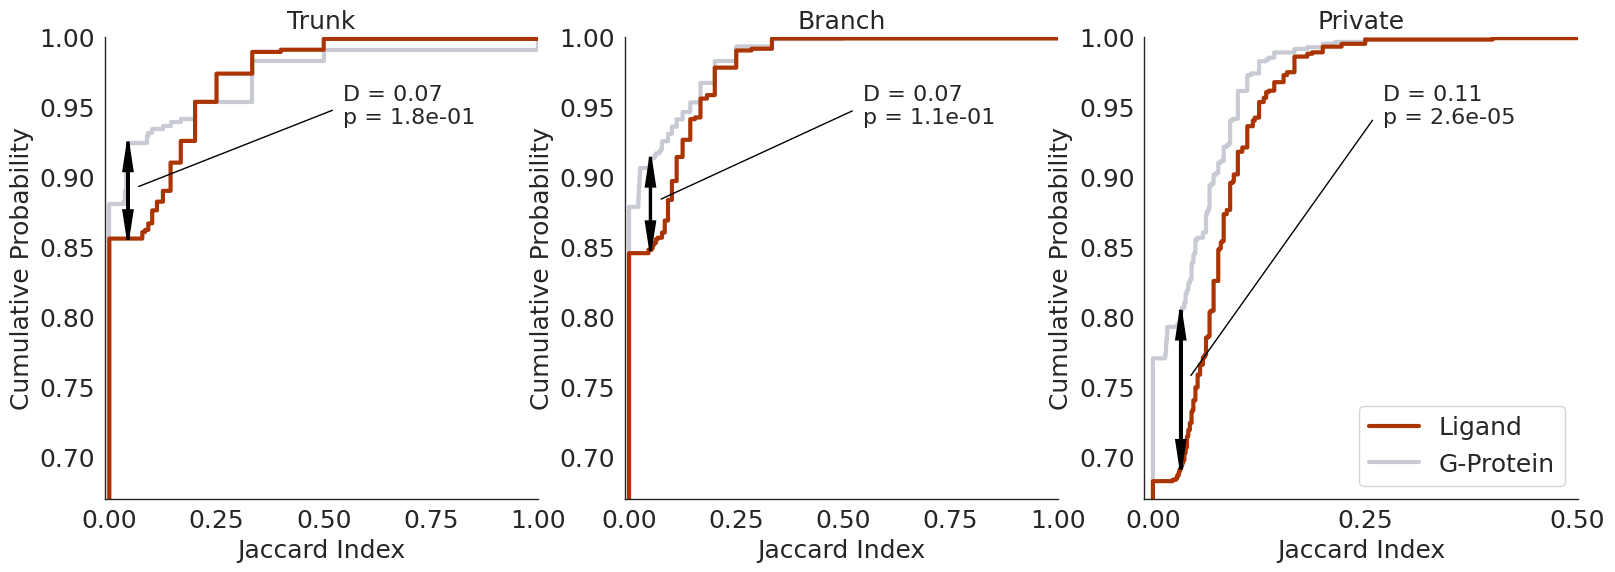

In [49]:
def plot_cdf_with_ks(data, condition, ax, color_ligand, color_gpcr):
    fs = 18

    # Set ylim and xlim based on condition
    ax.set_ylim(0.67, 1.)
    
    if condition == "Private":
        ax.set_xlim(-0.01, 0.5)
        arrow_width = 0.01  # half width
        ax.set_xticks([0, 0.25, 0.5])

    else:
        ax.set_xlim(-0.01, 1)
        arrow_width = 0.02  # default width
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.00])

    # Filter data for the given condition
    df_condition = data[data['condition'] == condition]
    ligand_values = df_condition[df_condition['interactor_type'] == 'Ligand']['value']
    gpcr_values = df_condition[df_condition['interactor_type'] == 'G-Protein']['value']
    
    # KS test
    ks_stat, p_value = ks_2samp(ligand_values, gpcr_values)

    # ECDF plots
    sns.ecdfplot(ligand_values, ax=ax, color=color_ligand, label='Ligand', linewidth=3, zorder=2)
    sns.ecdfplot(gpcr_values, ax=ax, color=color_gpcr, label='G-Protein', linewidth=3, zorder=1)

    # D-statistic logic
    cdf_ligand = np.sort(ligand_values)
    cdf_gpcr = np.sort(gpcr_values)
    all_values = np.sort(np.unique(np.concatenate((cdf_ligand, cdf_gpcr))))
    cdf_ligand_y = np.searchsorted(cdf_ligand, all_values, side='right') / len(cdf_ligand)
    cdf_gpcr_y = np.searchsorted(cdf_gpcr, all_values, side='right') / len(cdf_gpcr)
    max_diff_index = np.argmax(np.abs(cdf_ligand_y - cdf_gpcr_y))

    x_max_diff = all_values[max_diff_index]
    y1_max_diff = cdf_ligand_y[max_diff_index]
    y2_max_diff = cdf_gpcr_y[max_diff_index]
    midpoint_y = (y1_max_diff + y2_max_diff) / 2

    # Vertical D-statistic line and arrows
    ax.vlines(x_max_diff, y1_max_diff, y2_max_diff, color='k', linestyle='-', lw=2)
    ax.arrow(x_max_diff, y1_max_diff, 0, y2_max_diff - y1_max_diff, 
             color='k', linestyle='-', lw=2, head_width=arrow_width, head_length=0.02, length_includes_head=True, zorder=10)
    ax.arrow(x_max_diff, y2_max_diff, 0, y1_max_diff - y2_max_diff, 
             color='k', linestyle='-', lw=2, head_width=arrow_width, head_length=0.02, length_includes_head=True, zorder=10)

    # Annotation with KS stat
    text_object = ax.text(
        0.55, 0.85,
        f'D = {ks_stat:.2f}\np = {p_value:.1e}',
        fontsize=fs - 2, ha='left', va='center',
        transform=ax.transAxes,
    )

    text_x, text_y = text_object.get_position()
    max_diff_axis_rel = ax.transData.transform((x_max_diff, midpoint_y))
    max_diff_axis_rel_x, max_diff_axis_rel_y = ax.transAxes.inverted().transform(max_diff_axis_rel)

    direction_x = max_diff_axis_rel_x - text_x
    direction_y = max_diff_axis_rel_y - text_y

    offset_x = direction_x * 0.95
    offset_y = direction_y * 0.95

    start_x = text_x + offset_x
    start_y = text_y + offset_y
    end_x = max_diff_axis_rel_x - offset_x
    end_y = max_diff_axis_rel_y - offset_y

    ax.plot([start_x, end_x], [start_y, end_y], color='k', lw=1, linestyle='-', zorder=9, transform=ax.transAxes)

    # Axis labels and legend
    ax.set_title(f'{condition}', fontsize=fs)
    ax.set_xlabel('Jaccard Index', fontsize=fs)
    ax.set_ylabel('Cumulative Probability', fontsize=fs)
    ax.tick_params(labelsize=fs)
    ax.legend(fontsize=fs, loc='lower right')
    ax.grid(False)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a subplot mosaic with 1x3 grid layout
fig = plt.figure(figsize=(19, 6))

# Create the axes using the subplot mosaic
axes = fig.subplot_mosaic(
    """
    ABC
    """
)

# Plot for each condition
for i, condition in enumerate(df_jaccard['condition'].unique()):
    plot_cdf_with_ks(df_jaccard, condition, axes[chr(65 + i)], tcolor, lightgray)

# Remove legends from the first two axes
for ax in axes['A'], axes['B']:
    ax.legend_.remove()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/gpcrs/gpcrs_tumor_coevolution.png', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/gpcrs/gpcrs_tumor_coevolution.pdf', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# FULL FIGURE

In [50]:
# Function to run the KS test and return the KS statistic and p-value
def get_pvals_stats(data, condition):
    # Filter data for the given condition
    df_condition = data[data['condition'] == condition]
    ligand_values = df_condition[df_condition['interactor_type'] == 'Ligand']['value']
    gpcr_values = df_condition[df_condition['interactor_type'] == 'G-Protein']['value']

    # Perform KS test
    ks_stat, p_value = ks_2samp(ligand_values, gpcr_values)
    
    return ks_stat, p_value


In [51]:

def plot_cdf_with_ks(
    data,
    condition,
    ax,
    ks_stat,
    adjusted_p_value,
    color_ligand,
    color_gpcr, 
    ylim=None,
    xlim=None,    
    text_coords=(0.35, 0.85),
    text_ha='right',
):
    # Optionally set limits before plotting
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
        
    # Filter data for the given condition
    df_condition = data[data['condition'] == condition]
    ligand_values = df_condition[df_condition['interactor_type'] == 'Ligand']['value']
    gpcr_values = df_condition[df_condition['interactor_type'] == 'G-Protein']['value']

    # Plot the ECDFs
    sns.ecdfplot(gpcr_values, ax=ax, color=color_gpcr, label='G-Protein', linewidth=3, zorder=1)
    sns.ecdfplot(ligand_values, ax=ax, color=color_ligand, label='Ligand', linewidth=3, zorder=2)

    # Highlight the maximum difference (D-statistic)
    cdf_ligand = np.sort(ligand_values)
    cdf_gpcr = np.sort(gpcr_values)
    all_values = np.sort(np.unique(np.concatenate((cdf_ligand, cdf_gpcr))))
    cdf_ligand_y = np.searchsorted(cdf_ligand, all_values, side='right') / len(cdf_ligand)
    cdf_gpcr_y = np.searchsorted(cdf_gpcr, all_values, side='right') / len(cdf_gpcr)
    max_diff_index = np.argmax(np.abs(cdf_ligand_y - cdf_gpcr_y))

    x_max_diff = all_values[max_diff_index]
    y1_max_diff = cdf_ligand_y[max_diff_index]
    y2_max_diff = cdf_gpcr_y[max_diff_index]
    midpoint_y = (y1_max_diff + y2_max_diff) / 2

    head_width  = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
    head_length = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # D-statistic lines and arrows
    ax.vlines(x_max_diff, y1_max_diff, y2_max_diff, color='k', linestyle='-', lw=2)
    ax.arrow(x_max_diff, y1_max_diff, 0, y2_max_diff - y1_max_diff, 
             color='k', lw=2, head_width=head_width, head_length=head_length, length_includes_head=True, zorder=10)
    ax.arrow(x_max_diff, y2_max_diff, 0, y1_max_diff - y2_max_diff, 
             color='k', lw=2, head_width=head_width, head_length=head_length, length_includes_head=True, zorder=10)

    # Determine significance marker for p-value
    if adjusted_p_value < 0.001:
        significance = '***'
    elif adjusted_p_value < 0.01:
        significance = '**'
    elif adjusted_p_value < 0.05:
        significance = '*'
    else:
        significance = ''  # Not significant

    # D-statistic annotation with configurable position and alignment
    text_x, text_y = text_coords
    ax.text(
        text_x, text_y,
        f'D = {ks_stat:.2f}\np = {adjusted_p_value:.1e}\n{significance}',
        fontsize=fs, ha=text_ha, va='center',
        transform=ax.transAxes,
    )

    # Draw connector line to D-stat
    max_diff_axis_rel = ax.transData.transform((x_max_diff, midpoint_y))
    max_diff_axis_rel_x, max_diff_axis_rel_y = ax.transAxes.inverted().transform(max_diff_axis_rel)
    direction_x = max_diff_axis_rel_x - text_x
    direction_y = max_diff_axis_rel_y - text_y
    offset_x = direction_x * 0.85
    offset_y = direction_y * 0.85
    start_x = text_x + offset_x
    start_y = text_y + offset_y
    end_x = max_diff_axis_rel_x - offset_x
    end_y = max_diff_axis_rel_y - offset_y
    ax.plot([start_x, end_x], [start_y, end_y], color='k', lw=1, linestyle='-', zorder=9, transform=ax.transAxes)

    # Axes formatting
    ax.set_title(f'{condition}', fontsize=fs)
    ax.set_xlabel('Value', fontsize=fs)
    ax.set_ylabel('Cumulative Probability', fontsize=fs)
    ax.tick_params(labelsize=fs, direction='out')
    ax.legend(fontsize=fs, loc='lower right')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=True, left=True)  # Ensure ticks are visible
    ax.spines[['right', 'top']].set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        
    # Set ticks at a specific distance (e.g., 0.5 units)
    tick_distance = 0.5

    # Get the current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create tick positions based on the tick distance, starting from the lowest value within the limits
    x_ticks = np.arange(np.floor(xlim[0] / tick_distance) * tick_distance, 
                        np.ceil(xlim[1] / tick_distance) * tick_distance + tick_distance, 
                        tick_distance)
    y_ticks = np.arange(np.floor(ylim[0] / tick_distance) * tick_distance, 
                        np.ceil(ylim[1] / tick_distance) * tick_distance + tick_distance, 
                        tick_distance)

    # Filter ticks to ensure they are within the current axis limits
    x_ticks = x_ticks[(x_ticks >= xlim[0]) & (x_ticks <= xlim[1])]
    y_ticks = y_ticks[(y_ticks >= ylim[0]) & (y_ticks <= ylim[1])]

    # Apply the calculated ticks
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)



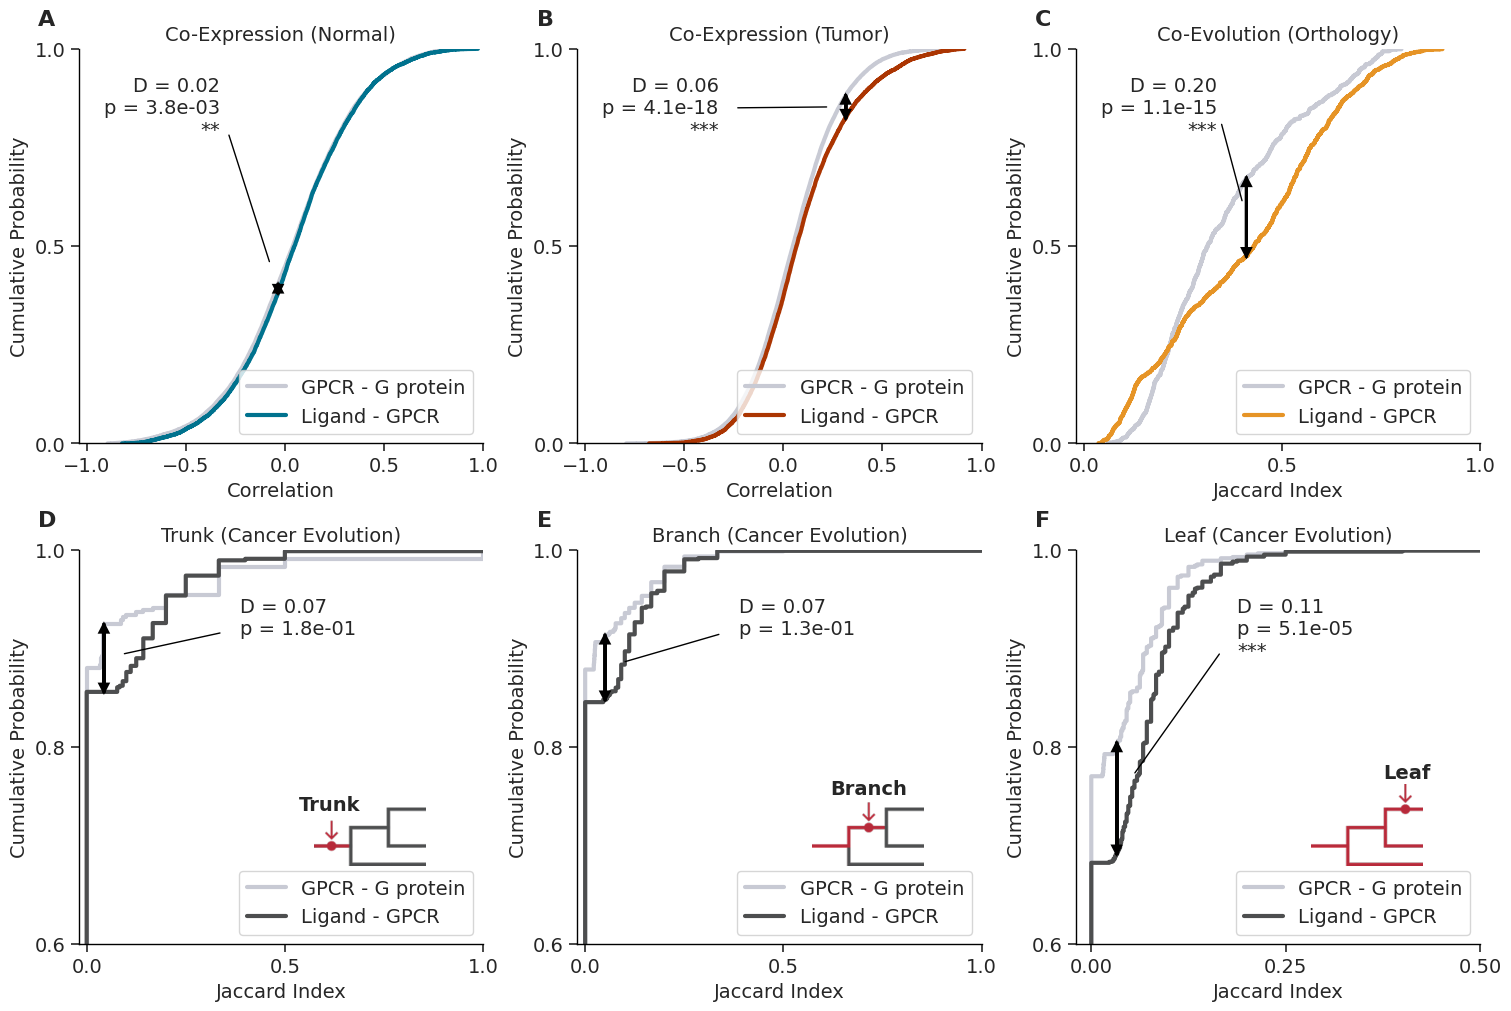

In [52]:
from scipy.stats import ks_2samp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fs = 14

# Create figure
fig, axes = plt.subplot_mosaic(
    mosaic="""
    ABC
    DEF
    """,
    figsize=(15, 10),
    constrained_layout=True
)

# Separate the conditions for df and df_jaccard
co_expression_conditions = ['Normal Co-Expression', 'Tumor Co-Expression', 'Coevolution']
jaccard_conditions = ['Trunk', 'Branch', 'Private']

ks_stats = []
p_vals = []

# Run KS test for co-expression conditions using df
for condition in co_expression_conditions:
    ks_stat, p_value = get_pvals_stats(df, condition)  # df for co-expression
    ks_stats.append(ks_stat)
    p_vals.append(p_value)

# Run KS test for Jaccard conditions using df_jaccard
for condition in jaccard_conditions:
    ks_stat, p_value = get_pvals_stats(df_jaccard, condition)  # df_jaccard for Jaccard indices
    ks_stats.append(ks_stat)
    p_vals.append(p_value)

# Apply FDR correction using false_discovery_control
corrected_pvals = false_discovery_control(p_vals)

# Co-expression plots — use defaults
plot_cdf_with_ks(df, 'Normal Co-Expression', axes['A'], ks_stats[0], corrected_pvals[0], ncolor, lightgray, xlim=(-1.04, 1))
plot_cdf_with_ks(df, 'Tumor Co-Expression', axes['B'], ks_stats[1], corrected_pvals[1], tcolor, lightgray, xlim=(-1.04, 1))
#plot_cdf_with_ks(df, 'Coevolution', axes['C'], ks_stats[2], corrected_pvals[2], orangecolor, lightgray, xlim=(-0.02, 1))
plot_cdf_with_ks(df, 'Coevolution', axes['C'], ks_stats[2], corrected_pvals[2], orangecolor, lightgray, xlim=(-0.02, 1))

# Jaccard plots — customize position and alignment
ylim_jaccard = (0.6, 1)
plot_cdf_with_ks(df_jaccard, 'Trunk'  , axes['D'], ks_stats[3], corrected_pvals[3], graycolor, lightgray, ylim=ylim_jaccard, xlim=(-0.02, 1), text_coords=(0.4, 0.8), text_ha='left')
plot_cdf_with_ks(df_jaccard, 'Branch' , axes['E'], ks_stats[4], corrected_pvals[4], graycolor, lightgray, ylim=ylim_jaccard, xlim=(-0.02, 1), text_coords=(0.4, 0.8), text_ha='left')
plot_cdf_with_ks(df_jaccard, 'Private', axes['F'], ks_stats[5], corrected_pvals[5], graycolor, lightgray, ylim=ylim_jaccard, xlim=(-0.02, 0.5), text_coords=(0.4, 0.8), text_ha='left')

# X-axis labels
axes['A'].set_xlabel('Correlation')
axes['B'].set_xlabel('Correlation')
axes['C'].set_xlabel('Jaccard Index')
axes['D'].set_xlabel('Jaccard Index')
axes['E'].set_xlabel('Jaccard Index')
axes['F'].set_xlabel('Jaccard Index')

# Titles
axes['A'].set_title('Co-Expression (Normal)', fontsize=fs)
axes['B'].set_title('Co-Expression (Tumor)', fontsize=fs)
axes['C'].set_title('Co-Evolution (Orthology)', fontsize=fs)
axes['D'].set_title('Trunk (Cancer Evolution)', fontsize=fs)
axes['E'].set_title('Branch (Cancer Evolution)', fontsize=fs)
axes['F'].set_title('Leaf (Cancer Evolution)', fontsize=fs)

axes['D'].set_xticks([0, 0.5, 1])
axes['E'].set_xticks([0, 0.5, 1])
axes['F'].set_xticks([0, 0.25, 0.5])

axes['D'].set_yticks([0.6, 0.8, 1])
axes['E'].set_yticks([0.6, 0.8, 1])
axes['F'].set_yticks([0.6, 0.8, 1])

icons_path = '/home/lnemati/pathway_crosstalk/data/coev_icons'

# === Icon controls ===
icon_scaling_factor = 0.25  # Adjust size of the icons

# === Add icons to panels D, E, and F ===
icon_files = {
    'D': 'trunk_reverse.png',
    'E': 'branch_reverse.png',
    'F': 'leaf_reverse.png',
}

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for panel, icon_name in icon_files.items():
    icon_path = os.path.join(icons_path, icon_name)
    if os.path.exists(icon_path):
        # Load and resize icon
        icon = Image.open(icon_path)
        width, height = icon.size
        icon_resized = icon.resize((int(width * icon_scaling_factor), int(height * icon_scaling_factor)))
        icon_array = np.array(icon_resized)

        # Create image box
        imagebox = OffsetImage(icon_array, zoom=0.5, resample=True)

        # Position in axes-relative coordinates (x=0.78, y=0.28 is consistent)
        ab = AnnotationBbox(
            imagebox,
            (0.72, 0.3),           # Position of the icon
            xycoords='axes fraction',
            frameon=False
        )

        axes[panel].add_artist(ab)

        # === Add label text above the icon ===
        label_map = {'D': 'Trunk', 'E': 'Branch', 'F': 'Leaf'}
        offsetx = {'D': -0.1,'E': 0, 'F': 0.1}
        offsety = {'D': -0.04,'E': 0, 'F': 0.04}
        axes[panel].text(
            0.72 + offsetx[panel],
            0.37 + offsety[panel],
            label_map[panel],
            transform=axes[panel].transAxes,
            ha='center',
            va='bottom',
            fontsize=fs,
            fontweight='bold'
        )

for ax in axes.values():
    ax.tick_params(length=6, width=1.2)

# === Add panel letters ===
panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for label, ax in zip(panel_labels, axes.values()):
    ax.text(
        -0.1, 1.1,  # Top-left corner in axes coords
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight='bold',
        va='top',
        ha='left'
    )
    

# In the legend replace 'G-Protein' with 'GPCR-Gprotein' and 'Ligand' with 'Ligand-GPCR'
for ax in axes.values():
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        if label == 'G-Protein':
            new_labels.append('GPCR - G protein')
        elif label == 'Ligand':
            new_labels.append('Ligand - GPCR')
        else:
            new_labels.append(label)
    ax.legend(handles, new_labels, fontsize=fs, loc='lower right')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/fig2.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/fig2.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/fig2.png', bbox_inches='tight', dpi=300)

plt.show()


In [53]:
fig_to_panels(fig, axes, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels')

Saved panel 'Co-Expression (Normal)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/co-expression_(normal)
Saved panel 'Co-Expression (Tumor)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/co-expression_(tumor)
Saved panel 'Co-Evolution (Orthology)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/co-evolution_(orthology)
Saved panel 'Trunk (Cancer Evolution)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/trunk_(cancer_evolution)
Saved panel 'Branch (Cancer Evolution)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/branch_(cancer_evolution)
Saved panel 'Leaf (Cancer Evolution)' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig2/panels/leaf_(cancer_evolution)


In [14]:
ncoev_jaccard = df.query('tissue == "Coevolution"')
df = pd.concat([ncoev_jaccard, pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/all_gpcr_interactions.csv')])

df.query('not (subtissue == "testis" and condition == "normal")')
df = df.groupby(['gpcr', 'interactor', 'condition', 'interactor_type', 'tissue', 'value_type'], as_index=False)['value'].mean()
df = df.query('value_type in ["correlation", "jaccard"]')
#df = df.query('value_type in ["adjacency", "jaccard"]')
df['condition'] =df['condition'].replace({'normal': 'Normal Co-Expression', 'tumor': 'Tumor Co-Expression'})


GPCRs
Normal vs Tumor Co-Expression: r = 0.415, p = 1.91e-09
Normal Co-Expression vs Coevolution: r = 0.054, p = 4.43e-01
Tumor Co-Expression vs Coevolution: r = -0.003, p = 9.66e-01


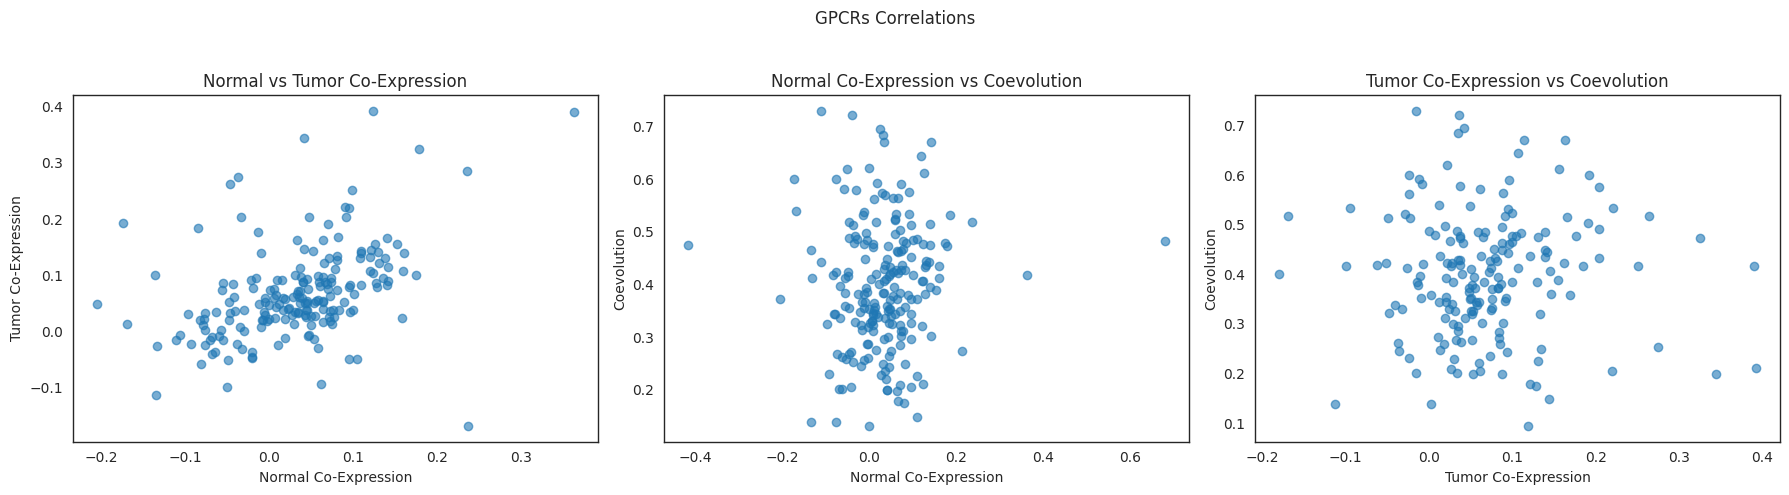


Ligand
Normal vs Tumor Co-Expression: r = 0.562, p = 4.16e-19
Normal Co-Expression vs Coevolution: r = 0.090, p = 1.65e-01
Tumor Co-Expression vs Coevolution: r = 0.204, p = 3.04e-03


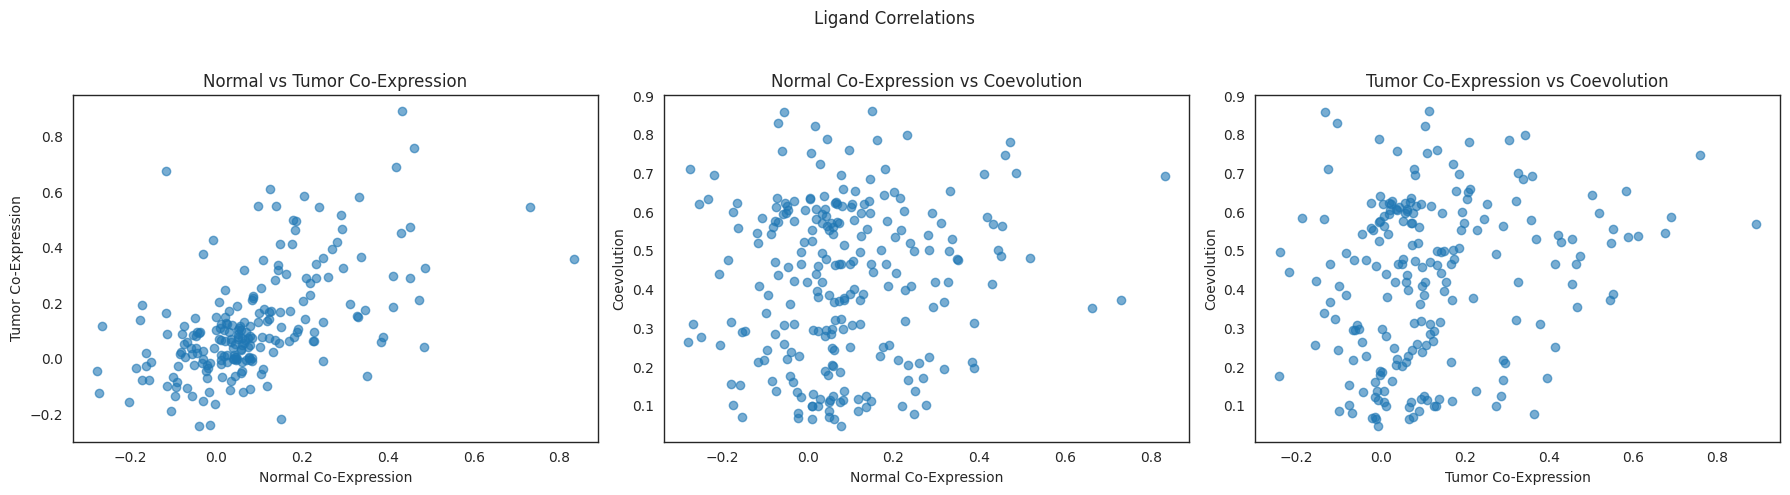


G-Protein
Normal vs Tumor Co-Expression: r = 0.825, p = 1.56e-04
Normal Co-Expression vs Coevolution: r = -0.060, p = 8.45e-01
Tumor Co-Expression vs Coevolution: r = -0.216, p = 4.78e-01


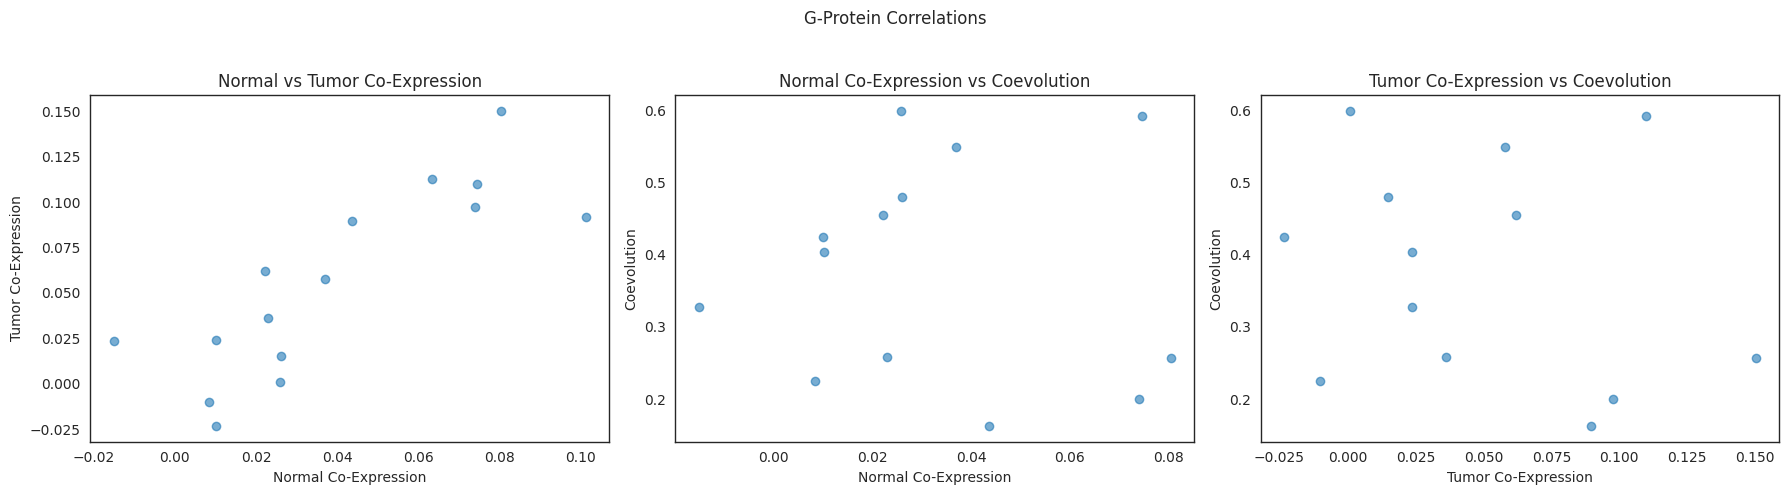

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

df['interaction'] = df.gpcr + '-' + df.interactor

def calc_and_plot(groupby_col, category_name):
    print(f'\n{category_name}')
    
    ddf = df.copy()
    if category_name in ['Ligand', 'G-Protein']:
        ddf = ddf.query('interactor_type == @category_name')
    
    # Get series for each condition
    ncoexpr = ddf.query('condition == "Normal Co-Expression"').groupby(groupby_col)['value'].mean()
    tcoexpr = ddf.query('condition == "Tumor Co-Expression"').groupby(groupby_col)['value'].mean()
    ncoev = ddf.query('condition == "Coevolution"').groupby(groupby_col)['value'].mean()

    # Shared indices for each pair
    n_t_shared = ncoexpr.index.intersection(tcoexpr.index)
    n_coev_shared = ncoexpr.index.intersection(ncoev.index)
    t_coev_shared = tcoexpr.index.intersection(ncoev.index)

    # Correlations and p-values
    def corr_p(x, y):
        if len(x) < 2:  # Not enough points for correlation
            return float('nan'), float('nan')
        return pearsonr(x, y)

    r_n_t, p_n_t = corr_p(ncoexpr[n_t_shared], tcoexpr[n_t_shared])
    r_n_coev, p_n_coev = corr_p(ncoexpr[n_coev_shared], ncoev[n_coev_shared])
    r_t_coev, p_t_coev = corr_p(tcoexpr[t_coev_shared], ncoev[t_coev_shared])

    print(f"Normal vs Tumor Co-Expression: r = {r_n_t:.3f}, p = {p_n_t:.2e}")
    print(f"Normal Co-Expression vs Coevolution: r = {r_n_coev:.3f}, p = {p_n_coev:.2e}")
    print(f"Tumor Co-Expression vs Coevolution: r = {r_t_coev:.3f}, p = {p_t_coev:.2e}")

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{category_name} Correlations')

    axs[0].scatter(ncoexpr[n_t_shared], tcoexpr[n_t_shared], alpha=0.6)
    axs[0].set_title('Normal vs Tumor Co-Expression')
    axs[0].set_xlabel('Normal Co-Expression')
    axs[0].set_ylabel('Tumor Co-Expression')

    axs[1].scatter(ncoexpr[n_coev_shared], ncoev[n_coev_shared], alpha=0.6)
    axs[1].set_title('Normal Co-Expression vs Coevolution')
    axs[1].set_xlabel('Normal Co-Expression')
    axs[1].set_ylabel('Coevolution')

    axs[2].scatter(tcoexpr[t_coev_shared], ncoev[t_coev_shared], alpha=0.6)
    axs[2].set_title('Tumor Co-Expression vs Coevolution')
    axs[2].set_xlabel('Tumor Co-Expression')
    axs[2].set_ylabel('Coevolution')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# GPCRs grouped by 'gpcr'
calc_and_plot('gpcr', 'GPCRs')

# Ligands grouped by 'interactor'
calc_and_plot('interactor', 'Ligand')

# G-Proteins grouped by 'interactor'
calc_and_plot('interactor', 'G-Protein')


In [39]:
import pandas as pd
from scipy.stats import pearsonr

df['interaction'] = df.gpcr + '-' + df.interactor

results = []

def compute_correlations_by_tissue(groupby_col, category_name, result_label):
    ddf = df.copy()
    ddf.query('interactor_type != "G-Protein"')
    if category_name in ['Ligand', 'G-Protein']:
        ddf = ddf.query('interactor_type == @category_name')

    tissues = ddf.query('condition != "Coevolution"')['tissue'].unique()
    
    for tissue in tissues:
        # Filter data
        ncoexpr = ddf.query('condition == "Normal Co-Expression" and tissue == @tissue').groupby(groupby_col)['value'].mean()
        tcoexpr = ddf.query('condition == "Tumor Co-Expression" and tissue == @tissue').groupby(groupby_col)['value'].mean()
        ncoev = ddf.query('condition == "Coevolution"').groupby(groupby_col)['value'].mean()

        # Shared indices
        n_coev_shared = ncoexpr.index.intersection(ncoev.index)
        t_coev_shared = tcoexpr.index.intersection(ncoev.index)

        def corr_p(x, y):
            if len(x) < 2:
                return float('nan'), float('nan')
            return pearsonr(x, y, alternative='greater')

        # Correlations
        r_n_coev, p_n_coev = corr_p(ncoexpr[n_coev_shared], ncoev[n_coev_shared])
        r_t_coev, p_t_coev = corr_p(tcoexpr[t_coev_shared], ncoev[t_coev_shared])

        # Append to results
        results.append({
            'tissue': tissue,
            'type': result_label,
            'normal_corr': r_n_coev,
            'normal_p': p_n_coev,
            'tumor_corr': r_t_coev,
            'tumor_p': p_t_coev
        })

# Run for each category
compute_correlations_by_tissue('gpcr', 'GPCRs', 'gpcr')
compute_correlations_by_tissue('interactor', 'Ligand', 'ligand')
#compute_correlations_by_tissue('interactor', 'G-Protein', 'gprot')

# Convert to DataFrame
result_df = pd.DataFrame(results)
result_df.loc[~result_df['normal_p'].isna(), 'normal_p'] = false_discovery_control(result_df.loc[~result_df['normal_p'].isna(), 'normal_p'])
result_df.loc[~result_df['tumor_p'].isna(), 'tumor_p'] = false_discovery_control(result_df.loc[~result_df['tumor_p'].isna(), 'tumor_p'])

In [42]:
result_df.sort_values(by='tumor_p').to_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/gene_scores.csv')
result_df.sort_values(by='tumor_p').to_csv('/home/lnemati/pathway_crosstalk/results/supplementary/gene_scores.csv')

In [60]:
result_df[result_df['normal_p'] < 0.05]['type'].value_counts()

Series([], Name: count, dtype: int64)

In [61]:
result_df[result_df['tumor_p'] < 0.05]['type'].value_counts()

type
ligand    24
gpcr       5
Name: count, dtype: int64

In [73]:
result_df[result_df['tumor_p'] < 0.05].tissue.nunique()

24

In [62]:
result_df.sort_values(by='tumor_corr', ascending=False).dropna().head(30).query('tissue == "breast"')

,tissue,type,normal_corr,normal_p,tumor_corr,tumor_p
47,breast,ligand,0.181533,0.276202,0.270157,0.006020
8,breast,gpcr,-0.010963,0.738848,0.235596,0.015427


In [66]:
df_original = df.copy()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


kidney


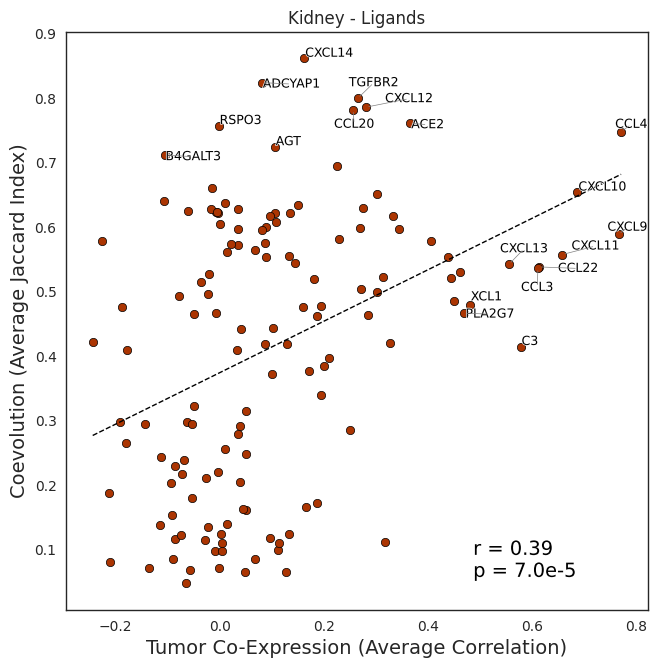

bile_duct


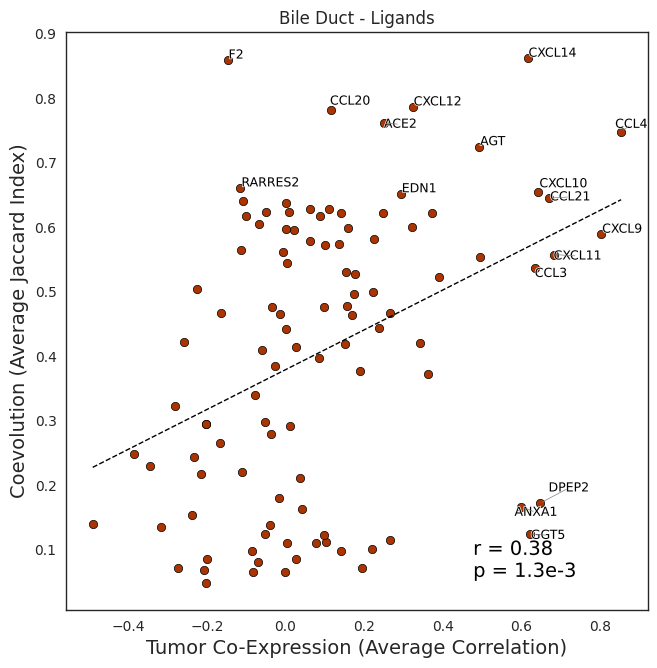

cervix


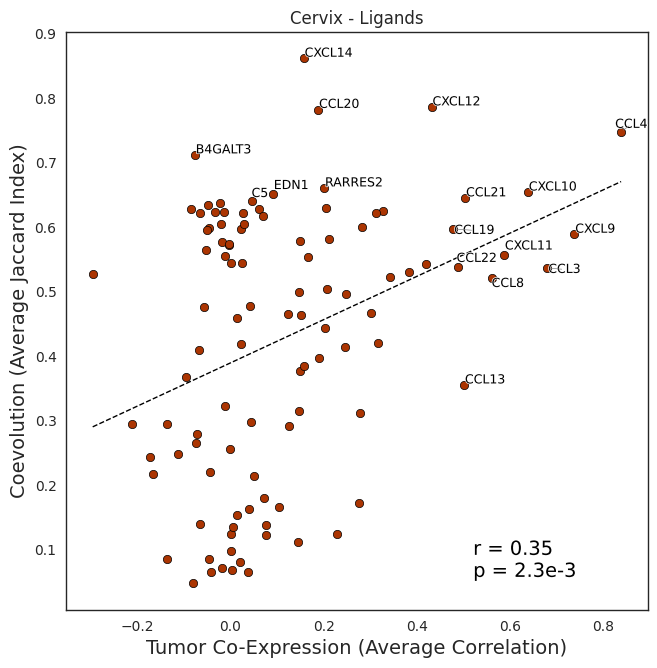

thyroid


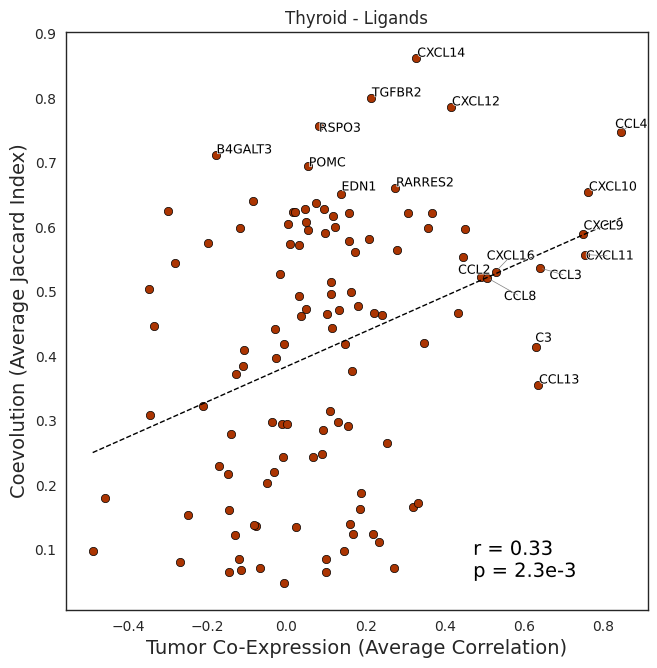

skin


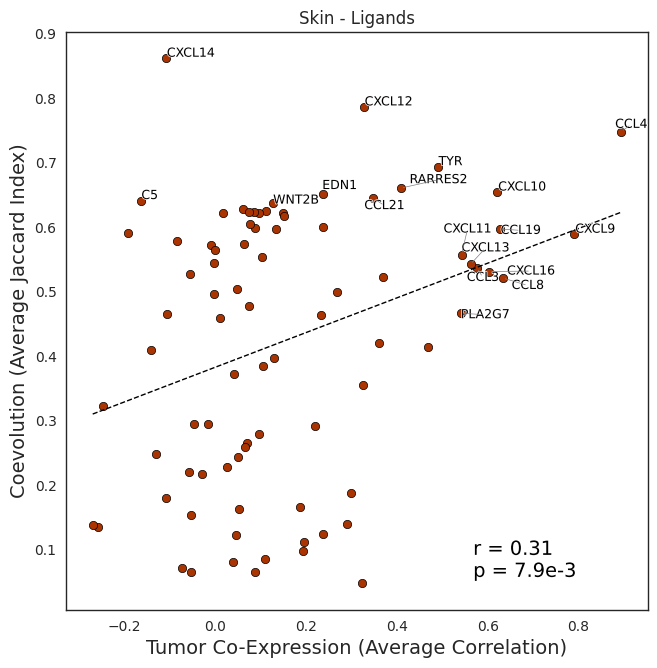

ovary


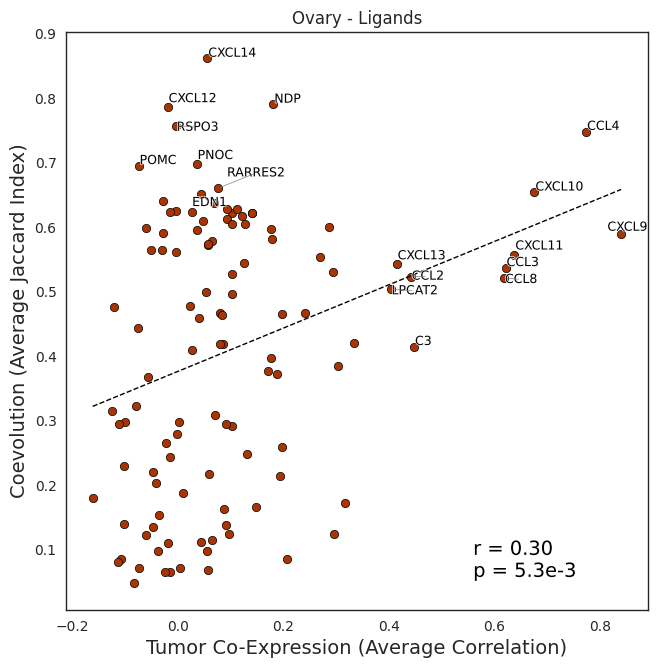

bladder


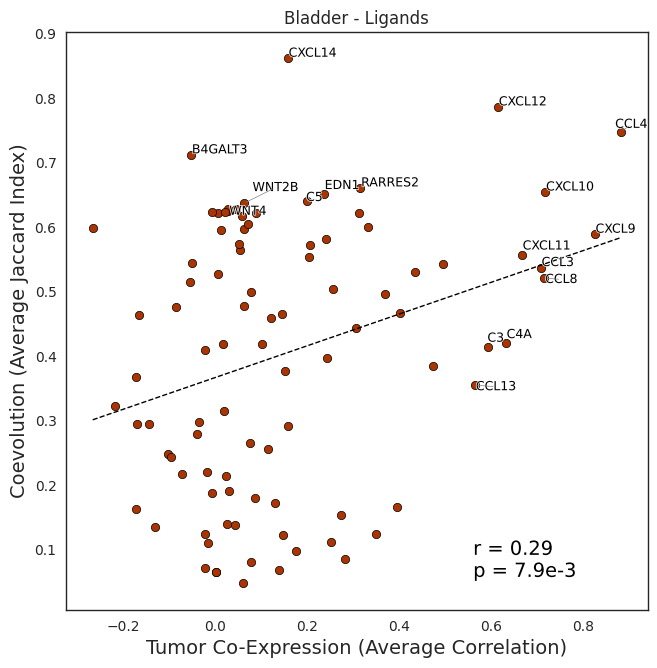

lung


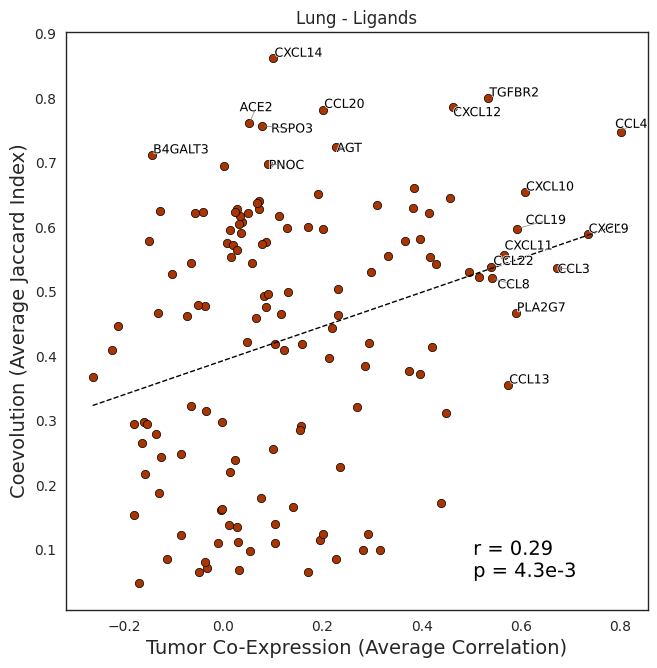

colon


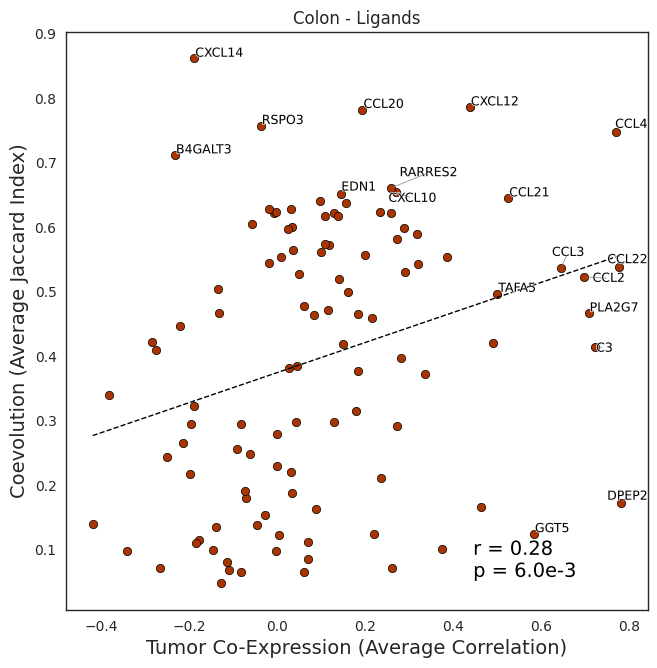

endometrium


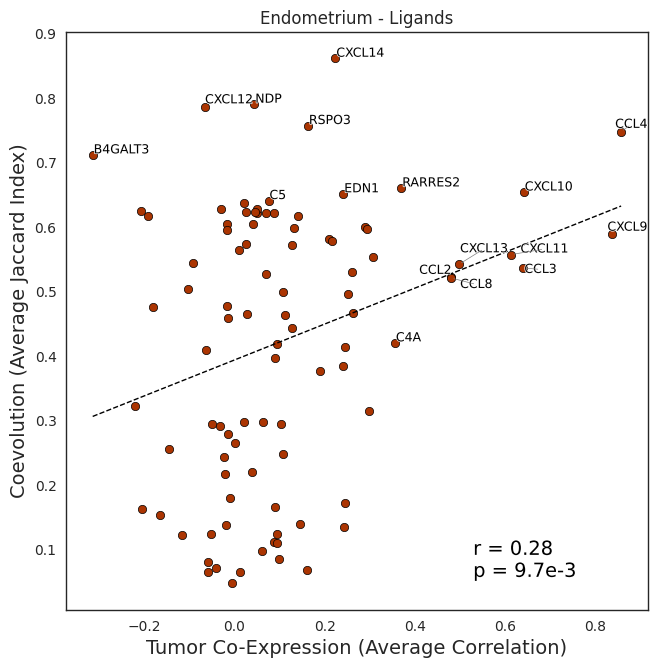

paraganglia


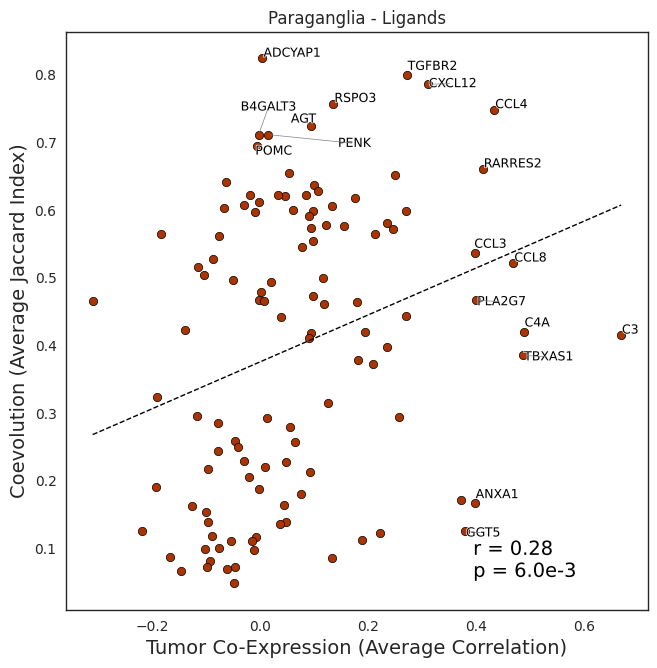

esophagus


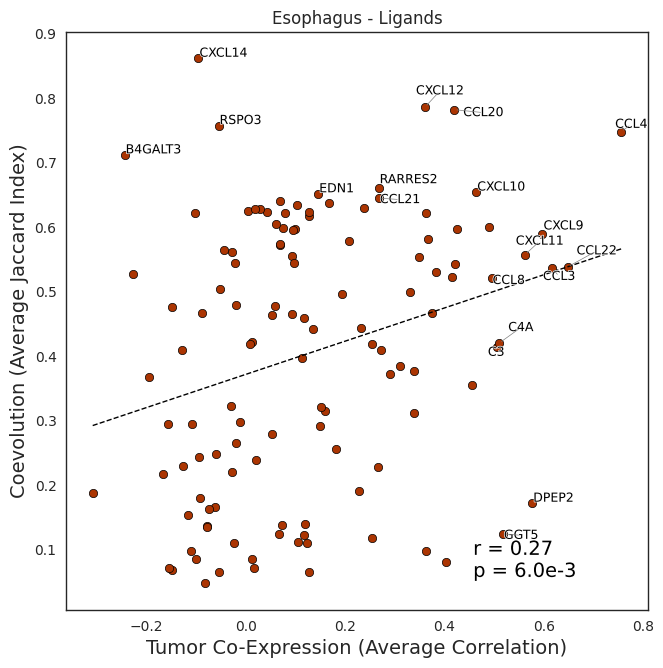

breast


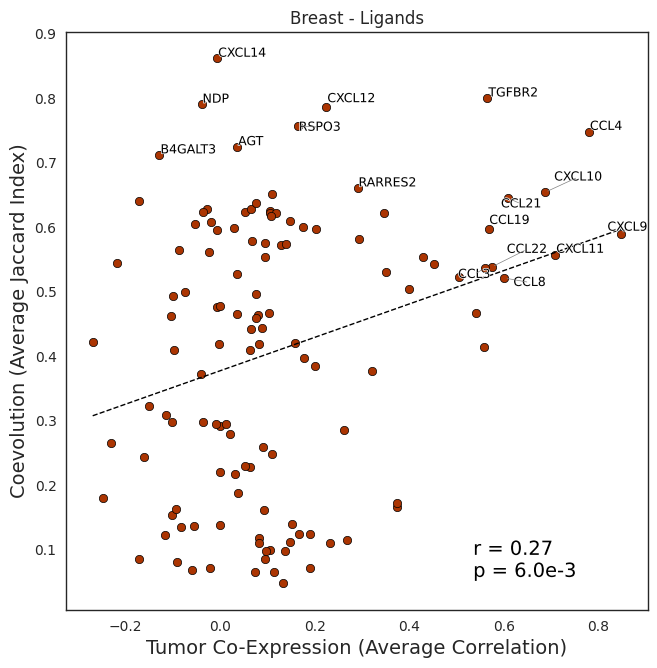

pancreas


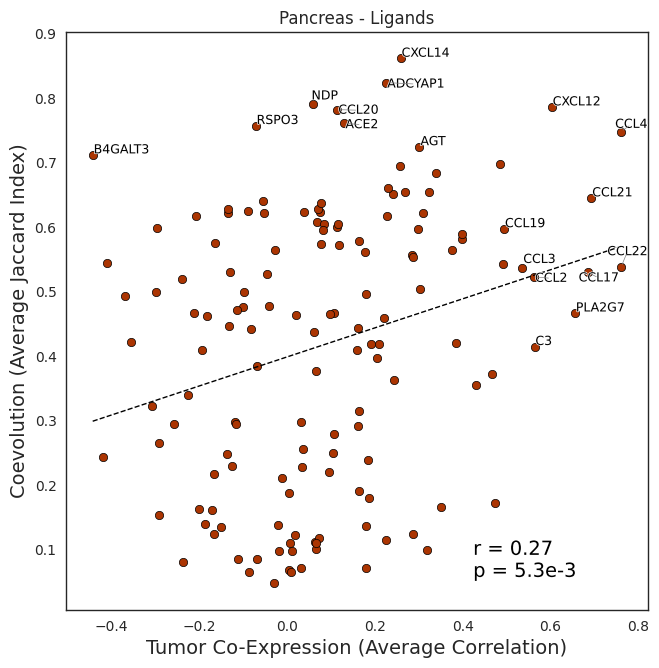

stomach


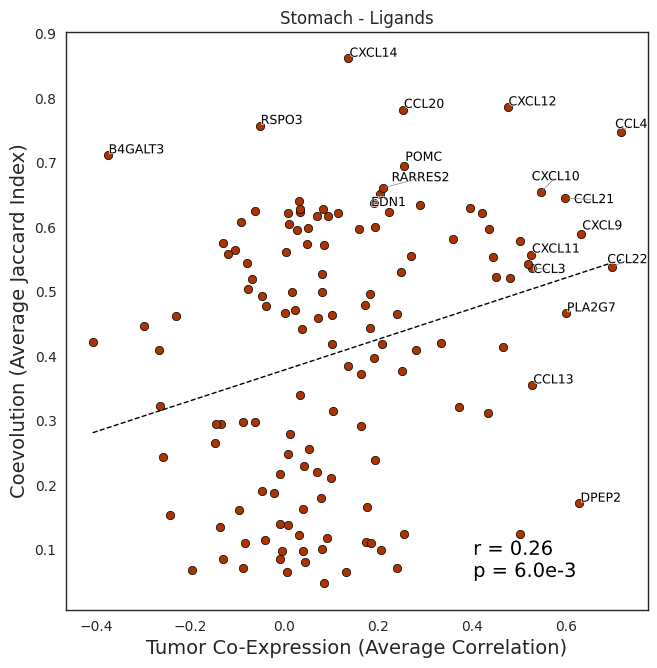

thymus


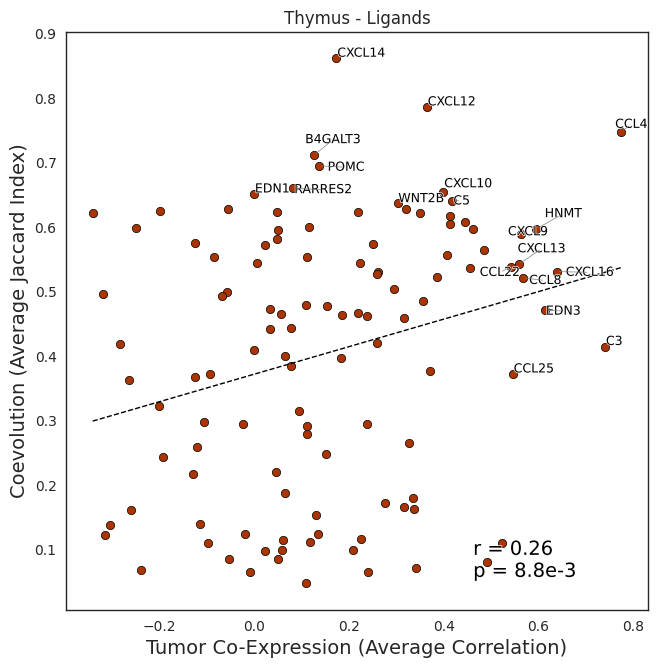

rectum


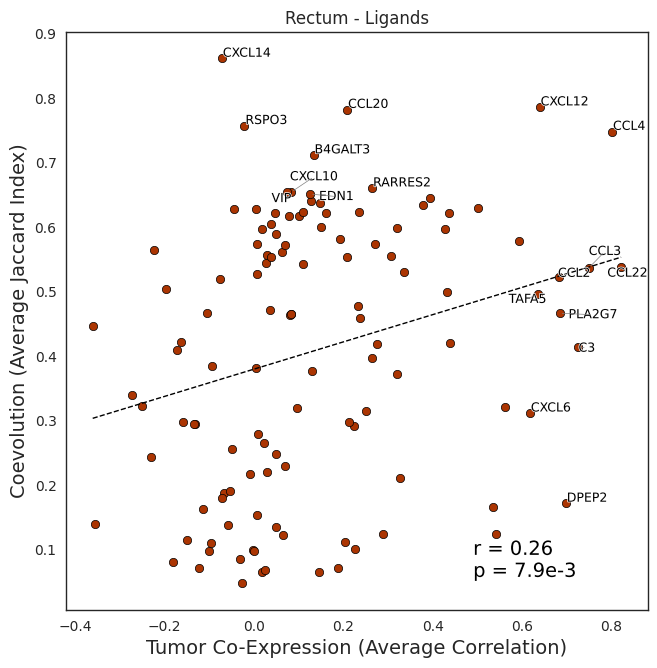

soft_tissue_bone


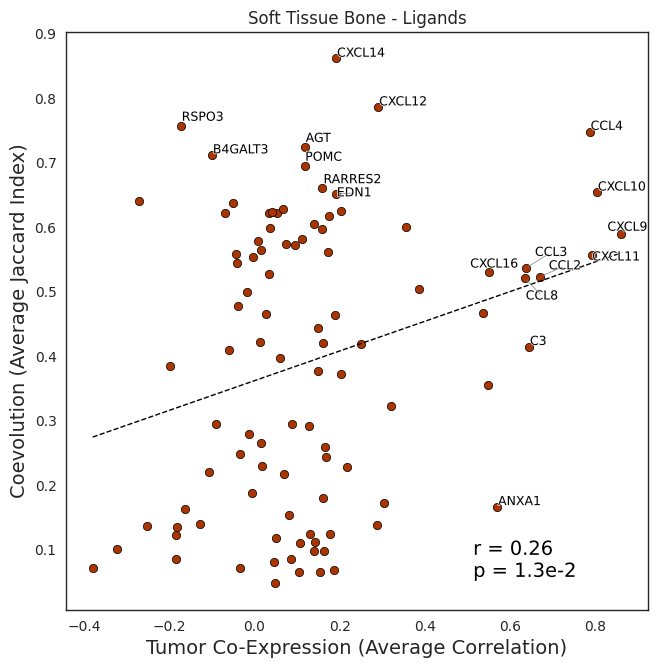

testis


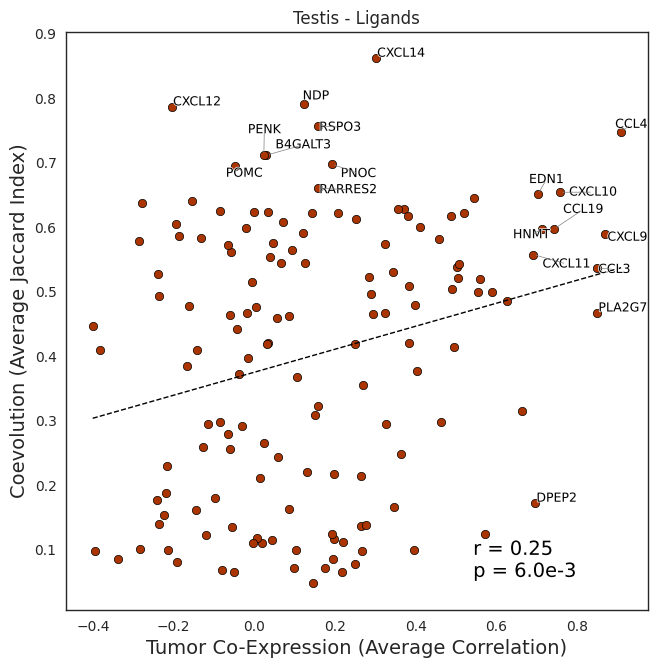

head_and_neck_region


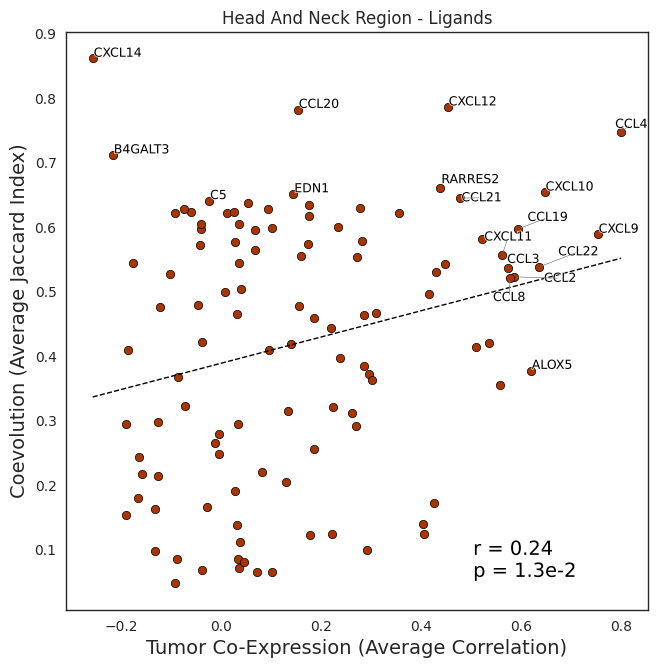

lining_of_body_cavities


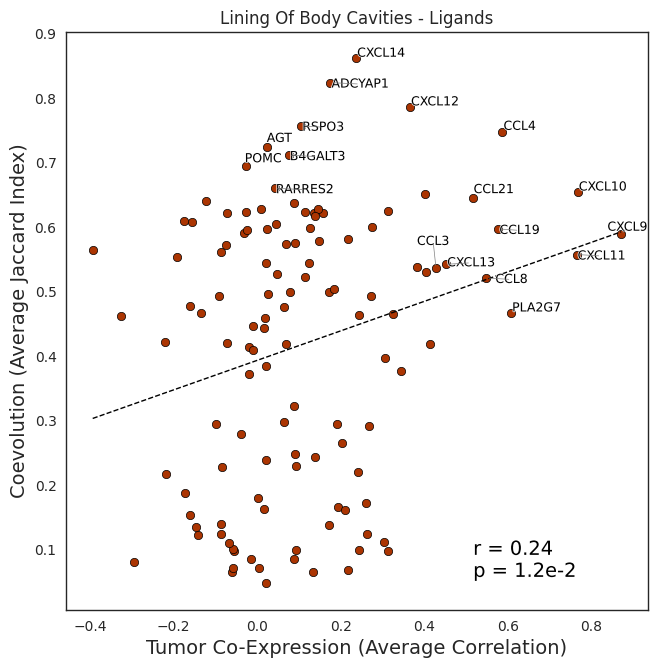

liver


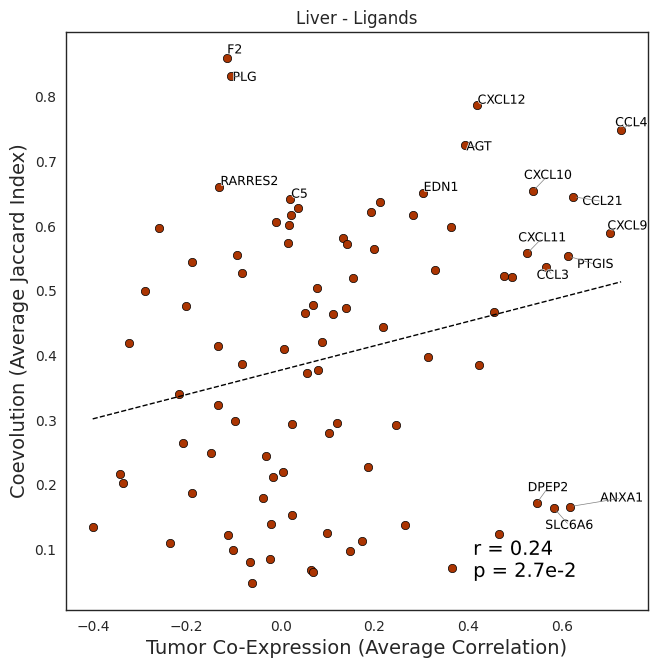

prostate


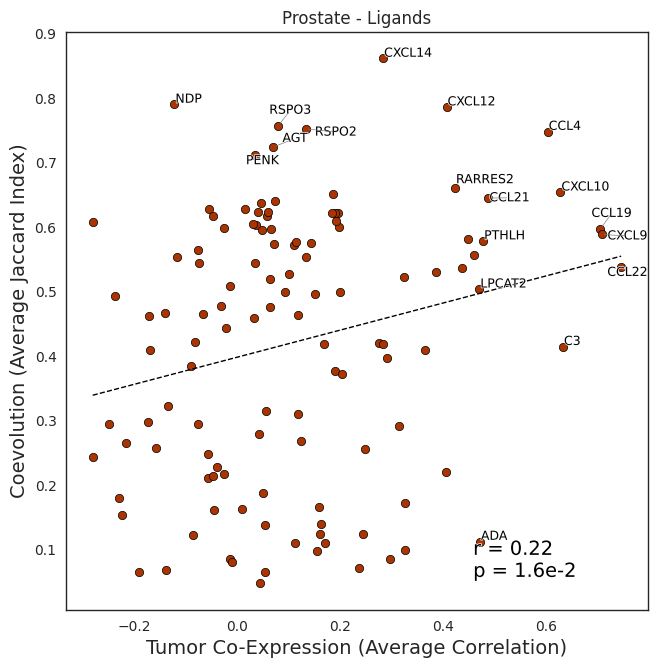

uterus


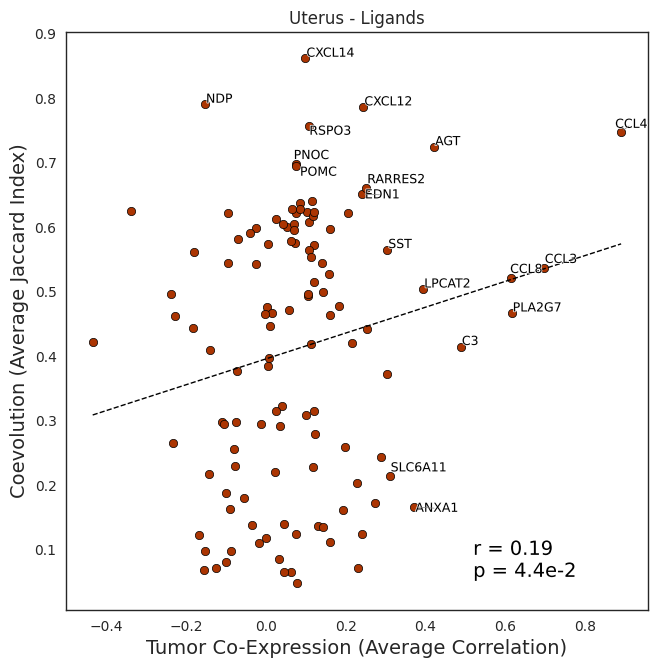

eye


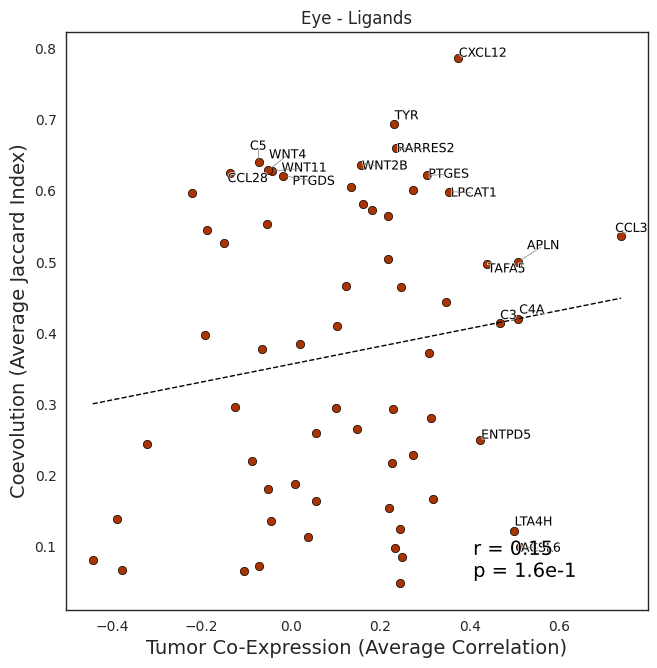

lymphatic_tissue


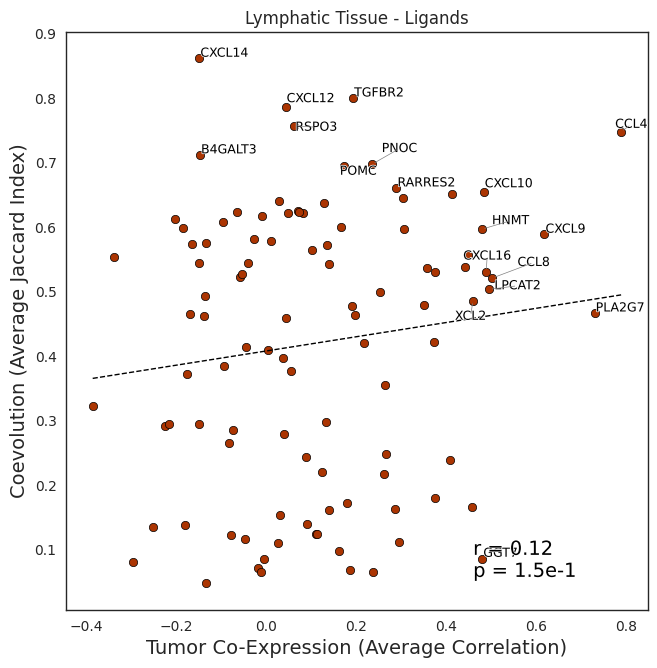

brain


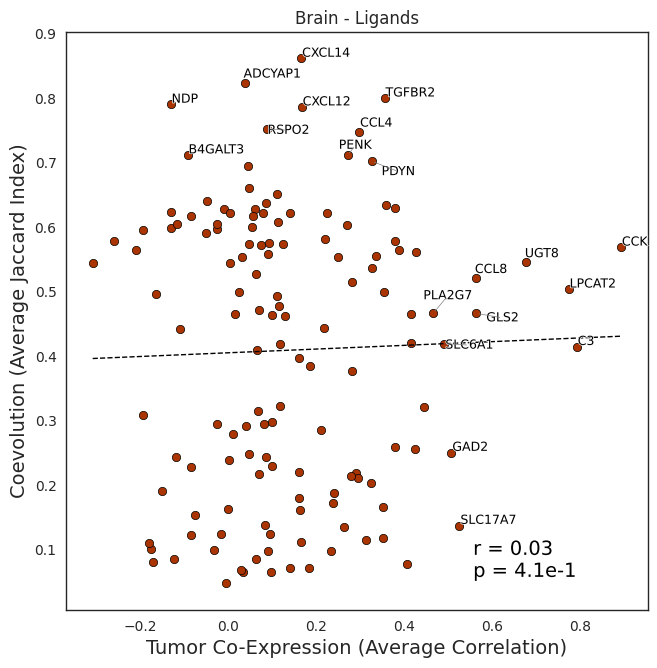

adrenal_gland


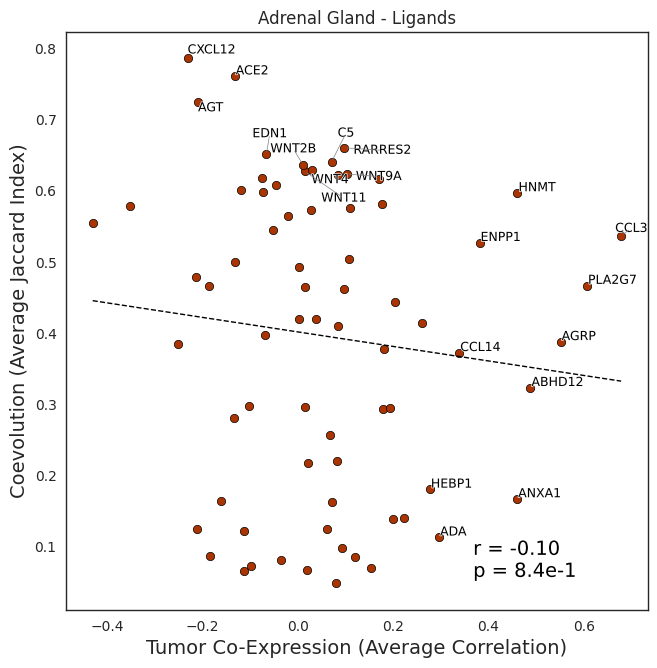

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import matplotlib.patheffects as path_effects
from decimal import Decimal

fs = 14

def plot_top_tissues(df, category, condition='tumor', top_n=5, groupby_col='gpcr', color='C0'):
    if category not in ['gpcr', 'ligand', 'gprot']:
        raise ValueError("category must be one of: 'gpcr', 'ligand', 'gprot'")
    if condition not in ['tumor', 'normal']:
        raise ValueError("condition must be 'tumor' or 'normal'")

    r_col = f'{condition}_corr'
    p_col = f'{condition}_p'

    filtered = df[(df['type'] == category) & df[r_col].notna()].copy()
    top_tissues = filtered.sort_values(r_col, ascending=False).head(top_n)['tissue'].values

    ddf = df_original.copy()
    if category == 'ligand':
        ddf = ddf.query('interactor_type == "Ligand"')
        name = 'Ligands'
    elif category == 'gprot':
        ddf = ddf.query('interactor_type == "G-Protein"')
        name = 'G Proteins'
    else:
        name = 'GPCRs'

    for tissue in top_tissues:
        print(tissue)
        # Get co-expression and coevolution values exactly as in correlation calculation
        coexpr = ddf.query(f'condition == "{condition.capitalize()} Co-Expression" and tissue == @tissue').groupby(groupby_col)['value'].mean()
        coev = ddf.query('condition == "Coevolution"').groupby(groupby_col)['value'].mean()

        shared = coexpr.index.intersection(coev.index)
        x = coexpr[shared]
        y = coev[shared]

        # Get stored correlation and p-value from df for this tissue
        r = filtered.loc[filtered['tissue'] == tissue, r_col].values[0]
        p = filtered.loc[filtered['tissue'] == tissue, p_col].values[0]

        
        # Fit regression line
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        x_sorted = np.sort(x)

        # Plot
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        scatter = ax.scatter(x, y, alpha=1, color=color, lw=0.5, edgecolor='k')
        ax.plot(x_sorted, fit_fn(x_sorted), color='black', linestyle='--', lw=1)

        # Identify top genes by coexpression and coevolution
        top_labels = 10
        top_x = x.sort_values(ascending=False).head(top_labels)
        top_y = y.sort_values(ascending=False).head(top_labels)
        to_label = top_x.index.union(top_y.index)

        # Add labels only to selected genes
        texts = []
        for label in to_label:
            texts.append(
                ax.text(
                    x[label], y[label], label, fontsize=9, alpha=1,
                    color='k',
                    path_effects=[
                        path_effects.Stroke(linewidth=1, foreground='white'),
                        path_effects.Normal()
                    ]
                )
            )


        # Adjust text positions to avoid overlap
        adjust_text(texts, ax=ax, explode=(7,7), expand=(1,1), force_text=(10.,10.), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

        ax.set_title(f"{tissue.title().replace('_', ' ')} - {name}")
        ax.set_xlabel(f"{condition.capitalize()} Co-Expression (Average Correlation)", fontsize=fs)
        ax.set_ylabel("Coevolution (Average Jaccard Index)", fontsize=fs)
        
        p_str = f"{Decimal(p):.1e}"  # Use Decimal to avoid floating point artifacts
        ax.text(
            0.7, 0.05, f"r = {r:.2f}\np = {p_str}",
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='bottom',
            color='k',
            path_effects=[
                path_effects.Stroke(linewidth=1, foreground='white'),
                path_effects.Normal()
            ]
        )
        
        #plt.tight_layout()
        plt.show()

plot_top_tissues(result_df, category='ligand', condition='tumor', top_n=40, groupby_col='interactor', color=tcolor)
#plot_top_tissues(result_df, category='gpcr', condition='normal', top_n=40, groupby_col='interactor', color=ncolor)

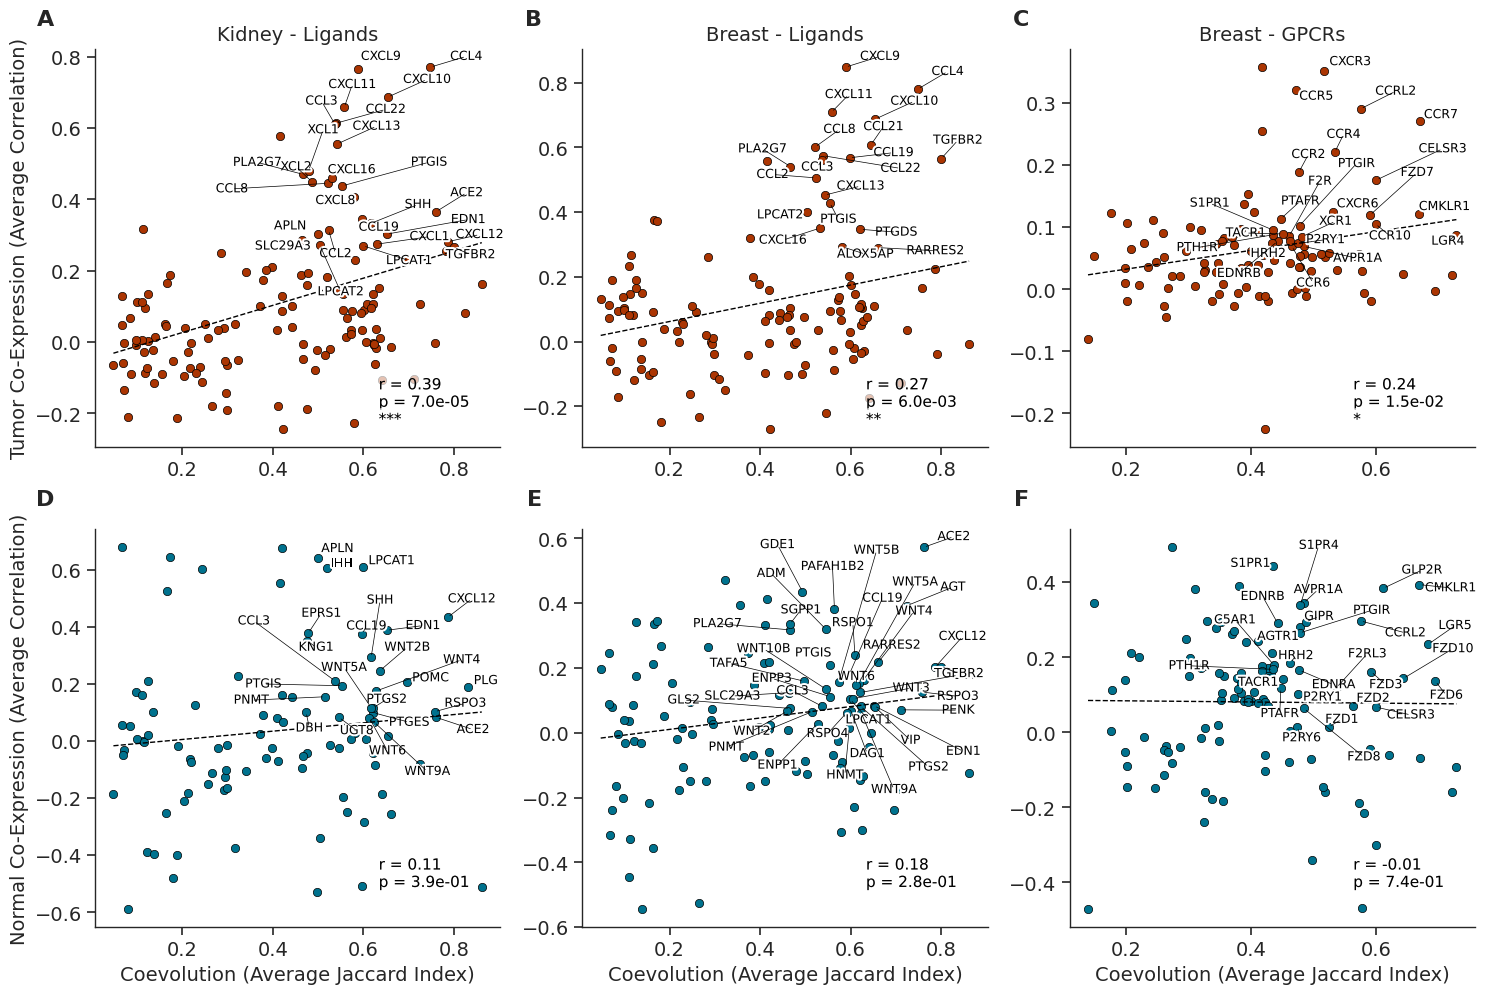

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import matplotlib.patheffects as path_effects
import string
from adjustText import adjust_text

fs = 14

def plot_tissue_panel(df, tissue_category_pairs, colors=('C0', 'C1')):
    n_cols = len(tissue_category_pairs)
    fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 10))  # No shared axes
    panel_labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']
    label_idx = 0

    for col_idx, (tissue, category) in enumerate(tissue_category_pairs):
        for row_idx, condition in enumerate(['tumor', 'normal']):
            ax = axes[row_idx, col_idx]

            # Dynamic groupby_col
            if category in ['ligand', 'gprot']:
                groupby_col = 'interactor'
            elif category == 'gpcr':
                groupby_col = 'gpcr'
            else:
                raise ValueError("Category must be one of: 'ligand', 'gprot', 'gpcr'")

            # Prep df
            r_col = f'{condition}_corr'
            p_col = f'{condition}_p'
            filtered = df[(df['type'] == category) & (df['tissue'] == tissue) & df[r_col].notna()]
            ddf = df_original.copy()

            if category == 'ligand':
                ddf = ddf.query('interactor_type == "Ligand"')
                name = 'Ligands'
            elif category == 'gprot':
                ddf = ddf.query('interactor_type == "G-Protein"')
                name = 'G Proteins'
            else:
                name = 'GPCRs'

            # Get coexpression (y-axis) and coevolution (x-axis)
            coexpr = ddf.query(f'condition == "{condition.capitalize()} Co-Expression" and tissue == @tissue').groupby(groupby_col)['value'].mean()
            coev = ddf.query('condition == "Coevolution"').groupby(groupby_col)['value'].mean()
            shared = coexpr.index.intersection(coev.index)
            x = coev[shared]
            y = coexpr[shared]

            # Regression
            fit = np.polyfit(x, y, 1)
            fit_fn = np.poly1d(fit)
            x_sorted = np.sort(x)

            # Plot points
            ax.scatter(x, y, alpha=1, color=colors[row_idx], lw=0.5, edgecolor='k')
            ax.plot(x_sorted, fit_fn(x_sorted), color='black', linestyle='--', lw=1)

            # Label only upper-right quadrant points
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            x_thresh = np.mean(xlim)
            y_thresh = np.mean(ylim)
            upper_right = x[(x > x_thresh) & (y > y_thresh)].index

            texts = []
            for label in upper_right:
                texts.append(
                    ax.text(
                        x[label], y[label], label, fontsize=9, alpha=1,
                        color='k',
                        path_effects=[
                            path_effects.Stroke(linewidth=3, foreground='white'),
                            path_effects.Normal()
                        ]
                    )
                )
            adjust_text(texts, ax=ax, explode=(7, 7), expand=(1, 1), force_text=(10., 10.),
                        arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

            # Stats
            if not filtered.empty:
                r = filtered[r_col].values[0]
                p = filtered[p_col].values[0]
                
            if p < 0.001:
                sgf = '***'
            elif p < 0.01:
                sgf = '**'
            elif p < 0.05:
                sgf = '*'
            else:
                sgf = ''
            
            ax.text(
                    0.7, 0.05, f"r = {r:.2f}\np = {p:.1e}\n{sgf}",
                    transform=ax.transAxes,
                    fontsize=11,
                    verticalalignment='bottom',
                    color='k',
                    path_effects=[
                        path_effects.Stroke(linewidth=7, foreground='white', alpha=0.7),
                        path_effects.Normal()
                    ]
                )

            # Titles and axis labels
            if row_idx == 0:
                ax.set_title(f"{tissue.title()} - {name}", fontsize=fs)
            if row_idx == 1:
                ax.set_xlabel("Coevolution (Average Jaccard Index)", fontsize=fs)
            else:
                ax.set_xlabel("")

            if col_idx == 0:
                ax.set_ylabel(f"{condition.capitalize()} Co-Expression (Average Correlation)", fontsize=fs)
            else:
                ax.set_ylabel("")
                
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(length=6, width=1.2, labelsize=fs, direction='out')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Add subplot label (e.g., A, B, C, D...) in row-wise order
            label_idx = row_idx * n_cols + col_idx
            ax.text(
                -0.1, 1.1, panel_labels[label_idx],
                fontsize=16, fontweight='bold',
                transform=ax.transAxes,
                va='top', ha='right'
            )

    plt.tight_layout()
    
    plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/gpcrs_scatterplot.png', bbox_inches='tight', dpi=300)
    plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/gpcrs_scatterplot.pdf', bbox_inches='tight', dpi=300)

    plt.show()

    
# Example usage:
tissue_category_pairs = [
    ('kidney', 'ligand'),
    ('breast', 'ligand'),
    ('breast', 'gpcr'),
]

plot_tissue_panel(result_df, tissue_category_pairs, colors=(tcolor, ncolor))
